In [1]:
import json
import time
import logging
import warnings
from pathlib import Path
from uuid import uuid4
from concurrent.futures import ThreadPoolExecutor, as_completed
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import cv2
import itertools
import threading
from concurrent.futures import as_completed
import math
import shutil
import random
import torch

warnings.filterwarnings("ignore", message="Got processor for bboxes, but no transform to process it")

class AugmentationPipeline:
    def __init__(self, config: dict, split: str = "train", logger=None):
        """
        Initialize configuration, directory structure, and parameters
        for the modular augmentation pipeline.
        """

        # ==========================================================
        # LOGGER SETUP
        # ==========================================================
        self.config = config
        self.split = split
        self.version = "v2.4.0"  # updated version marker

        log_cfg = config.get("logging", {})
        log_level = getattr(logging, log_cfg.get("level", "INFO").upper(), logging.INFO)

        self.logger = logger or logging.getLogger(f"AugmentationPipeline.{split}")
        self.logger.setLevel(log_level)

        if not self.logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter("[%(asctime)s] %(levelname)s: %(message)s", "%H:%M:%S")
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)
        self.logger.propagate = False

        # ==========================================================
        # PATH CONFIGURATION
        # ==========================================================
        self.root_dir = Path(config.get("output_dir", "data/outputs")).resolve()
        self.mirror_dir = self.root_dir / "mirror_clean"

        paths_cfg = config.get("paths", {})

        # --- Base clean dataset ---
        self.clean_dir = Path(paths_cfg.get("clean_dir", self.mirror_dir / f"{split}_clean")).resolve()
        self.clean_json = Path(paths_cfg.get("clean_json", self.clean_dir / f"{split}_clean.json")).resolve()

        # --- JSON fallback detection ---
        if not self.clean_json.exists():
            fallback_candidates = [
                self.clean_dir / f"{split}_joined.json",
                self.clean_dir / f"{split}.json"
            ]
            found = next((p for p in fallback_candidates if p.exists()), None)
            if found:
                self.clean_json = found
                self.logger.info(f"[INIT] Using fallback JSON -> {found}")
            else:
                json_candidates = list(self.clean_dir.glob("*.json"))
                if len(json_candidates) == 1:
                    self.clean_json = json_candidates[0]
                    self.logger.info(f"[INIT] Auto-detected clean JSON -> {self.clean_json}")
                else:
                    raise FileNotFoundError(f"[INIT] Missing clean JSON file in {self.clean_dir}")

        if not self.clean_dir.exists():
            raise FileNotFoundError(f"[INIT] Missing clean image directory: {self.clean_dir}")

        # ==========================================================
        # DIRECTORY STRUCTURE (Standardized for all stages)
        # ==========================================================
        self.prop_dir = self.mirror_dir / f"{split}_prop"
        self.rebalance_dir = self.mirror_dir / f"{split}_rebalance_1"
        self.zoom_dir = self.mirror_dir / f"{split}_zoom"
        self.final_dir = self.mirror_dir / f"{split}_final"

        for d in [self.prop_dir, self.rebalance_dir, self.zoom_dir, self.final_dir]:
            d.mkdir(parents=True, exist_ok=True)

        # --- Reports directory ---
        self.output_dir = self.root_dir / "reports"
        self.output_dir.mkdir(parents=True, exist_ok=True)

        # ==========================================================
        # JSON PATHS PER STAGE
        # ==========================================================
        self.prop_json = self.prop_dir / f"{split}_prop.json"
        self.rebalance_json = self.rebalance_dir / f"{split}_rebalance_1.json"
        self.zoom_json = self.zoom_dir / f"{split}_zoom.json"
        self.final_json = self.final_dir / f"{split}_final.json"

        # ==========================================================
        # AUGMENTATION PARAMETERS
        # ==========================================================
        aug_cfg = config.get("augmentations", {})

        def _to_float(val, default):
            try:
                return float(val)
            except (TypeError, ValueError):
                return default

        def _to_int(val, default):
            try:
                return int(val)
            except (TypeError, ValueError):
                return default

        self.mode = aug_cfg.get("mode", "none")
        self.proportion = _to_float(aug_cfg.get("proportion", 0.25), 0.25)
        self.tolerance = _to_float(aug_cfg.get("tolerance", 0.10), 0.10)
        self.max_repeats = _to_int(aug_cfg.get("max_repeats", 10), 10)
        self.min_unique_ratio = _to_float(aug_cfg.get("min_unique_ratio", 0.4), 0.4)
        self.max_boxes_per_image = _to_int(aug_cfg.get("max_boxes_per_image", 100), 100)
        self.min_images_per_class = _to_int(aug_cfg.get("min_images_per_class", 10), 10)
        self.transforms_cfg = aug_cfg.get("transforms", {})
        self.seed = _to_int(config.get("seed", 42), 42)
        self.num_workers = _to_int(config.get("num_workers", 4), 4)

        # ==========================================================
        # CLASS SETTINGS
        # ==========================================================
        self.classes = list(dict.fromkeys(config.get("classes", [])))  # remove duplicates, preserve order
        if not self.classes:
            raise ValueError("[INIT] No classes defined in configuration (config['classes']).")

        self.minority_strategy = aug_cfg.get("minority_strategy", "auto")  # "auto" or "bottom_n"
        self.bottom_n = _to_int(aug_cfg.get("bottom_n", 2), 2)

        if not (0 <= self.proportion <= 1):
            raise ValueError(f"[INIT] Invalid proportion value: {self.proportion}")
        if not (0 <= self.tolerance <= 1):
            raise ValueError(f"[INIT] Invalid tolerance value: {self.tolerance}")

        # ==========================================================
        # INTERNAL STATE
        # ==========================================================
        self.images = []
        self.annotations = []
        self.categories = []
        self.class_counts = {}
        self.pipeline = None
        self.sampling_plan = {}
        self.rebalance_plan = {}
        self.history = {}

        adaptive_flag = aug_cfg.get("adaptive_rebalance", False)
        self.logger.info(f"Adaptive rebalance={'ON' if adaptive_flag else 'OFF'}")

        # ==========================================================
        # FINAL VALIDATION LOG
        # ==========================================================
        self.logger.info("[INIT] Directory structure validated and configuration is consistent.")
        self.logger.info(f"[INIT] AugmentationPipeline ({self.version}) initialized for split='{split}'.")
        self.logger.info(
            f"Mode={self.mode} | Proportion={self.proportion} | Tolerance={self.tolerance} | "
            f"max_repeats={self.max_repeats} | min_unique_ratio={self.min_unique_ratio} | "
            f"max_boxes_per_image={self.max_boxes_per_image}"
        )

    def _filter_minority_images(self, anns: list[dict], cats: dict[int, str], minority_classes: list[str]) -> set[int]:
        """
        Identify and return image IDs that contain at least one annotation
        of any minority class. These are the only images eligible for the
        rebalance augmentation stage.
        """
        if not anns:
            self.logger.warning(f"[FILTER] ({self.split}) Empty annotation list. Returning empty set.")
            return set()
        if not cats:
            self.logger.warning(f"[FILTER] ({self.split}) Empty category mapping. Returning empty set.")
            return set()
        if not minority_classes:
            self.logger.info(f"[FILTER] ({self.split}) No minority classes provided. Nothing to filter.")
            return set()

        # --- Normalize class names (case-insensitive match) ---
        minority_norm = {c.lower().strip() for c in minority_classes}
        minority_cat_ids = {
            cid for cid, cname in cats.items()
            if cname and cname.lower().strip() in minority_norm
        }

        if not minority_cat_ids:
            self.logger.warning(f"[FILTER] ({self.split}) No matching category IDs found for minority classes.")
            return set()

        # --- Select eligible image IDs ---
        eligible_img_ids = {
            a["image_id"]
            for a in anns
            if "image_id" in a and a.get("category_id") in minority_cat_ids
        }

        # --- Reporting ---
        n_imgs = len(eligible_img_ids)
        n_min = len(minority_classes)

        if n_imgs == 0:
            self.logger.warning(f"[FILTER] ({self.split}) No eligible images found for {n_min} minority classes.")
        else:
            self.logger.info(
                f"[FILTER] ({self.split}) Eligible images for rebalance: {n_imgs} "
                f"(contain ≥1 of {n_min} minority classes)."
            )

        self.logger.debug(f"[FILTER] Minority classes ({n_min}): {minority_classes}")
        return eligible_img_ids

    def summarize_balance_from_json(self, json_path: Path) -> dict:
        """
        Compute class balance summary directly from a COCO-style JSON file.
        """
        if not Path(json_path).exists():
            raise FileNotFoundError(f"[SUMMARY] JSON file not found: {json_path}")

        try:
            with open(json_path, "r", encoding="utf-8") as f:
                data = json.load(f)
        except Exception as e:
            raise RuntimeError(f"[SUMMARY] Failed to read {json_path}: {e}")

        anns = data.get("annotations", [])
        cats = {c["id"]: c["name"] for c in data.get("categories", [])}
        if not anns or not cats:
            raise ValueError("[SUMMARY] Invalid or empty dataset structure.")

        # Count per class
        counts = {cname: 0 for cname in cats.values()}
        for ann in anns:
            cname = cats.get(ann["category_id"])
            if cname:
                counts[cname] += 1

        total = sum(counts.values())
        if total == 0:
            raise RuntimeError("[SUMMARY] No annotations found in dataset.")

        # Stats
        max_c = max(counts.values())
        min_c = min(counts.values())
        mean_c = np.mean(list(counts.values()))
        std_c = np.std(list(counts.values()))
        ratio = round(max_c / max(min_c, 1), 2)
        cv = round(std_c / max(mean_c, 1e-9), 3)
        deviation = {k: round((v - mean_c) / mean_c, 3) for k, v in counts.items()}
        tol = float(getattr(self, "tolerance", 0.1))
        within_tol = np.mean(np.abs(list(deviation.values()))) <= tol

        # Detect minority / majority
        threshold = mean_c * (1 - tol)
        minority = [k for k, v in counts.items() if v < threshold]

        self.logger.info(f"[SUMMARY] Class balance summary for {json_path.name}:")
        self.logger.info(f"       -> Max={max_c} | Min={min_c} | Mean={mean_c:.1f} | Ratio={ratio:.2f}")
        self.logger.info(f"       -> Std={std_c:.1f} | CV={cv:.3f} | Within tol={within_tol}")

        for cls, count in sorted(counts.items(), key=lambda x: -x[1]):
            delta = ((max_c - count) / max_c) * 100
            mark = "OK" if cls not in minority else "WARNING"
            self.logger.info(f"   - {cls:<15} {count:>6} Δ={delta:5.1f}% {mark}")

        return {
            "counts": counts,
            "max_count": max_c,
            "min_count": min_c,
            "mean_count": round(mean_c, 2),
            "std_count": round(std_c, 2),
            "cv": cv,
            "ratio": ratio,
            "minority_classes": minority,
            "within_tolerance": within_tol,
            "total_annotations": total,
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
        }

    def load_data(self) -> dict:
        """
        Load and validate COCO-style JSON with image and annotation metadata.
        Ensures internal consistency between image IDs and annotations.
        """
        if not self.clean_json.exists():
            raise FileNotFoundError(f"[LOAD] JSON not found: {self.clean_json}")
        try:
            with open(self.clean_json, "r", encoding="utf-8") as f:
                data = json.load(f)
            size_kb = round(Path(self.clean_json).stat().st_size / 1024, 1)
            self.logger.info(f"[LOAD] Loaded JSON ({size_kb} KB) from {self.clean_json}")
        except json.JSONDecodeError as e:
            raise ValueError(f"[LOAD] Invalid JSON format: {e}")

        # --- Extract core fields ---
        self.images = data.get("images", [])
        self.annotations = data.get("annotations", [])
        self.categories = data.get("categories", [])

        if not self.images:
            self.logger.warning(f"[LOAD] No images found in JSON ({self.clean_json}).")
        if not self.categories:
            self.logger.warning(f"[LOAD] No categories found in JSON ({self.clean_json}).")

        # --- Validate internal links ---
        valid_ids = {img.get("id") for img in self.images if "id" in img}
        before = len(self.annotations)
        self.annotations = [a for a in self.annotations if a.get("image_id") in valid_ids]
        removed = before - len(self.annotations)

        # --- Build class maps ---
        self.id2class = {c["id"]: c["name"] for c in self.categories if "id" in c and "name" in c}
        self.class2id = {v: k for k, v in self.id2class.items()}

        if not self.id2class:
            raise ValueError("[LOAD] No valid categories with 'id' and 'name' fields found.")

        # --- Detect inconsistencies between config and JSON ---
        missing_in_cfg = set(self.id2class.values()) - set(self.classes)
        extra_in_cfg = set(self.classes) - set(self.id2class.values())
        if missing_in_cfg:
            self.logger.warning(f"[LOAD] Classes in JSON not listed in config: {missing_in_cfg}")
        if extra_in_cfg:
            self.logger.info(f"[LOAD] Classes in config not present in JSON: {extra_in_cfg}")

        # --- Count annotations per class ---
        self.class_counts = {cls: 0 for cls in self.classes}
        for ann in self.annotations:
            cname = self.id2class.get(ann.get("category_id"))
            if cname in self.class_counts:
                self.class_counts[cname] += 1
            else:
                self.logger.debug(f"[LOAD] Unknown category_id={ann.get('category_id')} found in annotations.")

        # --- Integrity checks ---
        unique_image_ids = len(valid_ids)
        unique_ann_ids = len({a["id"] for a in self.annotations if "id" in a})

        if unique_ann_ids < len(self.annotations):
            self.logger.warning("[LOAD] Duplicate annotation IDs detected.")
        if len(valid_ids) < len(self.images):
            self.logger.warning("[LOAD] Duplicate image IDs detected.")
        if removed > 0:
            self.logger.warning(f"[LOAD] Removed {removed} orphan annotations (invalid image references).")
            
        n_imgs = len(self.images)
        n_anns = len(self.annotations)
        n_cls = len(self.categories)
        self.logger.info(f"[LOAD] Split '{self.split}' loaded successfully -> {n_imgs} images, {n_anns} annotations, {n_cls} classes.")

        return {
            "images": n_imgs,
            "annotations": n_anns,
            "classes": n_cls,
            "unique_images": unique_image_ids,
            "unique_annotations": unique_ann_ids,
            "removed_orphans": removed
        }

    def analyze_class_distribution(self, plot: bool = True) -> dict | None:
        """
        Compute and optionally visualize annotation counts per class.
        Returns a summary dict or None if empty.
        """
        # --- Ensure data is loaded ---
        if not self.class_counts:
            self.logger.warning(f"[ANALYZE] Class counts not initialized. Reloading split='{self.split}'.")
            self.load_data()
            if not self.class_counts:
                return None

        total = sum(self.class_counts.values())
        if total == 0:
            self.logger.warning(f"[ANALYZE] No annotations for split='{self.split}'.")
            return None

        # --- Build arrays ---
        classes = list(self.class_counts.keys())
        counts = np.array([self.class_counts[c] for c in classes], dtype=int)
        percents = np.round(100 * counts / total, 2)

        # --- Sort descending for clarity ---
        order = np.argsort(-counts)
        classes = [classes[i] for i in order]
        counts = counts[order]
        percents = percents[order]
        
        # --- Compute stats for consistency with post-rebalance evaluation ---
        max_c = int(counts.max())
        min_c = int(counts.min())
        mean_c = float(np.mean(counts))
        ratio = round(max_c / max(min_c, 1), 2)
        tol = float(getattr(self, "tolerance", 0.1))
        deviation_mean = float(np.mean(np.abs((counts - mean_c) / mean_c)))
        within_tolerance = deviation_mean <= tol


        # --- Logging summary ---
        self.logger.info(f"[ANALYZE] Annotation distribution for split='{self.split}':")
        for c, n, p in zip(classes, counts, percents):
            self.logger.info(f"   - {c:<15}: {n:>6} ({p:5.2f}%)")
        self.logger.info(f"   Total annotations: {int(total)}")

        # --- Plot visualization ---
        if plot:
            try:
                sns.set(style="whitegrid", font_scale=0.9)
                fig, ax = plt.subplots(figsize=(8, 4.5))
                palette = sns.color_palette("crest", len(classes))

                sns.barplot(x=classes, y=counts, ax=ax, palette=palette, legend=False)
                ax.set_ylim(0, max(counts) * 1.15)

                # Annotate counts and percentages
                offset = max(3, max(counts) * 0.02)
                for i, c in enumerate(classes):
                    ax.text(
                        i,
                        counts[i] + offset,
                        f"{counts[i]} ({percents[i]:.1f}%)",
                        ha="center",
                        va="bottom",
                        fontsize=9,
                        color="black"
                    )

                ax.set_title(f"Class Distribution - {self.split.upper()} (mean dev={deviation_mean:.3f}, tol={tol:.2f})", fontsize=12, fontweight="bold")
                ax.set_xlabel("Class")
                ax.set_ylabel("Number of Annotations")
                plt.xticks(rotation=25)
                plt.tight_layout()
                plt.show()

            except Exception as e:
                self.logger.warning(f"[ANALYZE] Plotting failed ({type(e).__name__}): {e}")

        return {
            "split": self.split,
            "classes": classes,
            "counts": counts.tolist(),
            "percents": percents.tolist(),
            "total": int(total),
            "max_count": max_c,
            "min_count": min_c,
            "mean_count": round(mean_c, 2),
            "ratio_max_min": ratio,
            "deviation_mean": round(deviation_mean, 4),
            "within_tolerance": within_tolerance,
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
        }

    def summarize_balance(self) -> dict:
        """
        Quantify imbalance ratios and identify minority/majority classes.
        Returns detailed per-class ratios, deviations, and global imbalance metrics.
        """
        # --- Ensure data ---
        if not self.class_counts:
            self.load_data()
        counts = self.class_counts
        if not counts:
            self.logger.warning(f"[BALANCE] No class counts found for split='{self.split}'.")
            return {}

        # --- Basic stats ---
        values = np.array(list(counts.values()), dtype=float)
        max_count = float(np.max(values))
        min_count = float(np.min(values))
        mean_count = float(np.mean(values))
        std_count = float(np.std(values))
        tol = float(self.tolerance)

        if mean_count == 0:
            self.logger.warning(f"[BALANCE] Empty dataset (mean count = 0) for split='{self.split}'.")
            return {}

        total_count = int(np.sum(values))
        cv = round(std_count / mean_count, 3)

        # --- Ratios and deviations ---
        ratios_to_max = {cls: round(cnt / max_count, 3) for cls, cnt in counts.items()}
        ratios_to_mean = {cls: round(cnt / mean_count, 3) for cls, cnt in counts.items()}
        deviation_signed = {cls: (cnt - mean_count) / mean_count for cls, cnt in counts.items()}
        deviation_abs = {cls: abs(v) for cls, v in deviation_signed.items()}

        # --- Determine minority and majority classes ---
        if getattr(self, "minority_strategy", "auto") == "bottom_n":
            if len(counts) <= self.bottom_n:
                self.logger.warning("[BALANCE] bottom_n strategy ignored (fewer classes than N).")
                minority, majority = [], []
            else:
                sorted_classes = sorted(counts.items(), key=lambda x: x[1])
                minority = [cls for cls, _ in sorted_classes[: self.bottom_n]]
                majority = [cls for cls, _ in sorted(counts.items(), key=lambda x: -x[1])[: self.bottom_n]]
                self.logger.info(f"[BALANCE] Using fixed bottom_n strategy ({self.bottom_n}).")
        else:
            minority = [cls for cls, dev in deviation_abs.items() if counts[cls] < mean_count and dev > tol]
            majority = [cls for cls, dev in deviation_abs.items() if counts[cls] > mean_count and dev > tol]

        imbalance_ratio = round(max_count / max(min_count, 1), 2)
        balanced_within_tol = not (minority or majority)

        self.logger.info(
            f"[BALANCE] Split='{self.split}' | tol={tol:.2f} | ratio={imbalance_ratio:.2f} | CV={cv:.3f}"
        )
        self.logger.info(
            f"[BALANCE] Max={max_count:.0f} ({max(counts, key=counts.get)}) | "
            f"Min={min_count:.0f} ({min(counts, key=counts.get)}) | Mean={mean_count:.1f}"
        )

        for cls, cnt in sorted(counts.items(), key=lambda x: -x[1]):
            rmax = ratios_to_max[cls]
            rmean = ratios_to_mean[cls]
            devp = deviation_signed[cls] * 100
            mark = "🔻" if cls in minority else ("🔺" if cls in majority else "")
            self.logger.info(
                f"   {cls:<15}: count={cnt:<6} | r_max={rmax:.3f} | r_mean={rmean:.3f} | Δ={devp:6.1f}% {mark}"
            )

        if minority:
            self.logger.info(f"[BALANCE] Minority ({len(minority)}): {minority}")
        if majority:
            self.logger.info(f"[BALANCE] Majority ({len(majority)}): {majority}")
        if balanced_within_tol:
            self.logger.info("[BALANCE] Dataset appears balanced within tolerance range.")

        return {
            "split": self.split,
            "total_annotations": total_count,
            "max_class": max(counts, key=counts.get),
            "min_class": min(counts, key=counts.get),
            "max_count": int(max_count),
            "min_count": int(min_count),
            "mean_count": round(mean_count, 2),
            "std_count": round(std_count, 2),
            "cv": cv,
            "ratios_to_max": ratios_to_max,
            "ratios_to_mean": ratios_to_mean,
            "deviation_signed": deviation_signed,
            "minority_classes": minority,
            "majority_classes": majority,
            "imbalance_ratio": imbalance_ratio,
            "balanced_within_tol": balanced_within_tol,
            "tolerance": tol
        }

    def set_seed_everywhere(self) -> dict:
        """
        Fix global random seeds across all supported modules for full reproducibility.

        Ensures deterministic behavior for:
        - Python's random module
        - NumPy random generator
        - PyTorch (CPU and CUDA, if available)
        """

        # ==========================================================
        # 🔹 Validate and normalize seed
        # ==========================================================
        try:
            self.seed = int(self.seed)
        except Exception:
            self.seed = 42
            if hasattr(self, "logger") and self.logger:
                self.logger.warning("[SETUP] Invalid seed type detected, fallback to 42.")

        # ==========================================================
        # 🔹 Set Python and NumPy seeds
        # ==========================================================
        random.seed(self.seed)
        np.random.seed(self.seed)

        cuda_available = False

        # ==========================================================
        # 🔹 PyTorch seed handling
        # ==========================================================
        try:
            import torch
            torch.manual_seed(self.seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(self.seed)
                torch.backends.cudnn.deterministic = True
                torch.backends.cudnn.benchmark = False

                try:
                    torch.use_deterministic_algorithms(True)
                except Exception:
                    # Compatible fallback for older torch versions
                    pass

                cuda_available = True
        except ModuleNotFoundError:
            if hasattr(self, "logger") and self.logger:
                self.logger.debug("[SETUP] PyTorch not installed — skipping CUDA seeding.")
        except Exception as e:
            if hasattr(self, "logger") and self.logger:
                self.logger.warning(f"[SETUP] Error while seeding PyTorch: {e}")

        # ==========================================================
        # 🔹 Logging and return
        # ==========================================================
        if hasattr(self, "logger") and self.logger:
            self.logger.info(f"[SETUP] Global seed fixed → {self.seed} | CUDA available: {cuda_available}")

        return {"seed": self.seed, "cuda_available": cuda_available}

    def prepare_transforms(self):
        """
        Dynamically build Albumentations pipeline from configuration.
        Each transform inside the pipeline is applied independently according to
        its individual probability `p`. The whole pipeline runs once per image
        (ReplayCompose has p=1.0).
        """
        cfg_aug = self.config.get("augmentations", {})

        if not cfg_aug.get("enabled", False):
            self.logger.info("[AUGMENT] Augmentations disabled in configuration.")
            self.pipeline = None
            return None

        transforms_dict = cfg_aug.get("transforms", {})
        if not transforms_dict:
            raise ValueError("[AUGMENT] No transforms defined in config['augmentations']['transforms'].")

        aug_list = []
        for name, params in transforms_dict.items():
            p = float(params.get("p", 0.5))  # individual transform probability

            try:
                transform_cls = getattr(A, name, None)
                if transform_cls is None:
                    self.logger.warning(f"[AUGMENT] Unknown transform '{name}' ignored.")
                    continue

                # Default border mode for Rotate
                if name == "Rotate" and "border_mode" not in params:
                    params["border_mode"] = cv2.BORDER_REFLECT_101

                # Filter out invalid keys
                valid_params = {k: v for k, v in params.items() if k != "p"}

                transform = transform_cls(**valid_params, p=p)
                aug_list.append(transform)

            except Exception as e:
                self.logger.warning(f"[AUGMENT] Error initializing '{name}': {e}")
                continue

        if not aug_list:
            raise ValueError("[AUGMENT] No valid transforms found after parsing configuration.")

        try:
            aug_blocks = []
            # Always ensure at least one transform is applied
            aug_blocks.append(A.OneOf(aug_list, p=1.0))
            # Optional: apply a second random combination (if SomeOf is supported)
            try:
                aug_blocks.append(A.SomeOf(aug_list, n=2, replace=False, p=0.3))
            except Exception:
                self.logger.warning("[AUGMENT] A.SomeOf not supported in this Albumentations version. Skipping secondary block.")

            self.pipeline = A.ReplayCompose(
                aug_blocks,
                bbox_params=A.BboxParams(
                    format="coco",
                    label_fields=["category_ids"],
                    min_visibility=0.25  # discard boxes mostly out of frame
                ),p=1.0  # pipeline always executed, internal transforms decide individually
            )
        except Exception as e:
            raise RuntimeError(f"[AUGMENT] Failed to build Albumentations pipeline: {e}")

        used_transforms = [t.__class__.__name__ for t in aug_list]
        self.logger.info(f"[AUGMENT] Albumentations pipeline created successfully.")
        self.logger.info(f"          Includes {len(aug_list)} transforms: {', '.join(used_transforms)}")

        avg_prob = np.mean([t.p for t in aug_list])
        self.logger.info(f"[AUGMENT] Expected average of {len(aug_list)*avg_prob:.2f} transforms applied per image (stochastically).")

        return self.pipeline

    def apply_global_proportional_augmentation(self) -> dict:
        """
        Apply Albumentations augmentation to a random global subset of clean images.
        Each augmented image is saved into `{split}_prop/` and logged in `{split}_prop.json`.

        Ensures:
        - Consistent naming convention
        - Unique IDs offset from the original dataset
        - Thread-safe augmentation and JSON export
        """

        # ==========================================================
        # 🔹 Preconditions
        # ==========================================================
        if not isinstance(self.pipeline, A.ReplayCompose):
            raise RuntimeError("[PROP] Albumentations pipeline not initialized. Run prepare_transforms() first.")
        if not self.clean_json.exists():
            raise FileNotFoundError(f"[PROP] Clean JSON not found: {self.clean_json}")

        # ==========================================================
        # 🔹 Load base dataset
        # ==========================================================
        with open(self.clean_json, "r", encoding="utf-8") as f:
            data = json.load(f)

        images = {img["id"]: img for img in data.get("images", [])}
        anns = data.get("annotations", [])
        cats = data.get("categories", [])

        if not images or not cats:
            raise ValueError("[PROP] Empty clean dataset or missing categories.")

        # ==========================================================
        # 🔹 Setup proportional output directory
        # ==========================================================
        self.prop_dir.mkdir(parents=True, exist_ok=True)
        start_time = time.time()

        # ==========================================================
        # 🔹 Sampling configuration
        # ==========================================================
        rng = np.random.default_rng(self.seed)
        total_imgs = len(images)
        n_to_aug = max(1, int(total_imgs * self.proportion))
        sampled_ids = rng.choice(list(images.keys()), size=n_to_aug, replace=False)

        self.logger.info(f"[PROP] Selected {n_to_aug}/{total_imgs} images ({self.proportion * 100:.1f}%) for augmentation.")

        # ==========================================================
        # 🔹 Safe ID offsets (prevent collisions)
        # ==========================================================
        max_img_id = max(images.keys(), default=0)
        max_ann_id = max((a["id"] for a in anns), default=0)
        img_id_counter = itertools.count(start=max_img_id + 1)
        ann_id_counter = itertools.count(start=max_ann_id + 1)
        id_lock = threading.Lock()

        # ==========================================================
        # 🔹 Category lookup
        # ==========================================================
        cat_lookup = {c["id"]: c["name"] for c in cats}
        img_class_map = {
            a["image_id"]: cat_lookup.get(a["category_id"], "Unknown")
            for a in anns
        }

        new_images, new_anns = [], []

        # ==========================================================
        # 🔹 Inner augmentation function
        # ==========================================================
        def _augment_image(img_id, cls_name):
            try:
                img_entry = images.get(img_id)
                if not img_entry:
                    return None

                fname = Path(img_entry["file_name"]).name
                img_path = next(
                    (p for p in [self.clean_dir / fname, self.clean_dir / "images" / fname] if p.exists()),
                    None
                )
                if img_path is None:
                    return None

                with Image.open(img_path) as im:
                    img = np.array(im.convert("RGB"))

                anns_img = [a for a in anns if a["image_id"] == img_id]
                if not anns_img:
                    return None

                bboxes = [a["bbox"] for a in anns_img]
                labels = [a["category_id"] for a in anns_img]

                transformed = self.pipeline(image=img, bboxes=bboxes, category_ids=labels)
                if not transformed or not transformed.get("bboxes"):
                    return None

                aug_img = np.clip(transformed["image"], 0, 255).astype(np.uint8)
                if aug_img.size == 0:
                    return None

                h, w = aug_img.shape[:2]
                clamped_bboxes = []
                for bbox in transformed["bboxes"]:
                    x, y, bw, bh = bbox
                    x = max(0, min(x, w - 1))
                    y = max(0, min(y, h - 1))
                    bw = max(1.0, min(bw, w - x))
                    bh = max(1.0, min(bh, h - y))
                    clamped_bboxes.append([x, y, bw, bh])

                # --- Assign new image ID and save ---
                with id_lock:
                    new_img_id = next(img_id_counter)
                new_name = f"{Path(fname).stem}_prop_{uuid4().hex[:8]}.jpg"
                out_path = self.prop_dir / new_name
                Image.fromarray(aug_img).save(out_path, format="JPEG", quality=95)

                new_images.append({
                    "id": new_img_id,
                    "file_name": new_name,
                    "orig_file": fname,
                    "width": w,
                    "height": h,
                    "source_stage": "proportional"
                })

                # --- Annotations ---
                for bbox, cid in zip(clamped_bboxes, transformed["category_ids"]):
                    with id_lock:
                        ann_id = next(ann_id_counter)
                    new_anns.append({
                        "id": ann_id,
                        "image_id": new_img_id,
                        "category_id": cid,
                        "bbox": [float(x) for x in bbox],
                        "area": float(bbox[2] * bbox[3]),
                        "iscrowd": 0,
                        "source_stage": "proportional"
                    })

                return True

            except Exception as e:
                self.logger.debug(f"[PROP] Error augmenting image {img_id}: {e}")
                return None

        # ==========================================================
        # 🔹 Parallel execution
        # ==========================================================
        with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
            futures = [
                executor.submit(_augment_image, int(img_id), img_class_map.get(int(img_id), "Unknown"))
                for img_id in sampled_ids
            ]
            for _ in tqdm(as_completed(futures), total=len(futures), desc=f"Proportional augment {self.split}"):
                pass  # Progress bar only; results appended inside threads

        # ==========================================================
        # 🔹 Save JSON
        # ==========================================================
        json_out = {
            "images": new_images,
            "annotations": new_anns,
            "categories": cats,
            "_meta": {
                "split": self.split,
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
                "total_images": len(new_images),
                "total_annotations": len(new_anns)
            }
        }

        with open(self.prop_json, "w", encoding="utf-8") as f:
            json.dump(json_out, f, indent=2)

        # ==========================================================
        # 🔹 Logging and return
        # ==========================================================
        duration = round(time.time() - start_time, 2)
        self.logger.info(f"[PROP] Completed proportional augmentation for split='{self.split}'.")
        self.logger.info(f"       -> {len(new_images)} new images | {len(new_anns)} annotations | {duration:.2f}s")
        self.logger.info(f"       -> JSON saved to {self.prop_json}")

        return {
            "split": self.split,
            "augmented_images": len(new_images),
            "augmented_annotations": len(new_anns),
            "output_dir": str(self.prop_dir),
            "json_path": str(self.prop_json),
            "duration_sec": duration,
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
        }

    def define_rebalance_strategy(self) -> dict:
        """
        Define the base corrective strategy for class imbalance.

        This stage determines numeric targets and actions per class.
        It does NOT yet decide which specific images to augment - that
        is handled by plan_rebalance_sampling().
        """
        # 1. Validate mode
        if self.mode not in ["over", "under"]:
            self.logger.warning(f"[REBALANCE] Invalid mode='{self.mode}'. Expected 'over' or 'under'. Skipping stage.")
            self.rebalance_plan = {}
            return {}

        counts = {cls: 0 for cls in self.classes}

        # 2. Load clean dataset counts
        if self.clean_json.exists():
            with open(self.clean_json, "r", encoding="utf-8") as f:
                clean_data = json.load(f)
            clean_cats = {c["id"]: c["name"] for c in clean_data.get("categories", [])}
            for ann in clean_data.get("annotations", []):
                cname = clean_cats.get(ann["category_id"])
                if cname in counts:
                    counts[cname] += 1
        else:
            self.logger.warning("[REBALANCE] Clean JSON not found. Counts may be incomplete.")

        # 3. Add proportional dataset counts if available
        if self.prop_json.exists():
            with open(self.prop_json, "r", encoding="utf-8") as f:
                prop_data = json.load(f)
            prop_cats = {c["id"]: c["name"] for c in prop_data.get("categories", [])}

            # Optional consistency check
            if set(clean_cats.values()) != set(prop_cats.values()):
                self.logger.warning("[REBALANCE] Category mismatch detected between clean and proportional datasets.")

            for ann in prop_data.get("annotations", []):
                cname = prop_cats.get(ann["category_id"])
                if cname in counts:
                    counts[cname] += 1
            self.logger.info("[REBALANCE] Combined counts from clean + proportional datasets.")
        else:
            self.logger.warning("[REBALANCE] Proportional JSON not found. Using clean counts only.")

        # 4. Validate counts
        self.class_counts = counts
        if not counts or all(v == 0 for v in counts.values()):
            raise RuntimeError("[REBALANCE] No valid counts found in datasets.")

        summary = self.summarize_balance()
        max_count = summary.get("max_count", 0)
        min_count = summary.get("min_count", 0)
        tol = float(self.tolerance)
        rebalance_plan = {}

        # 5. Define strategy based on mode
        if self.mode == "over":
            target = int(max_count * (1 - tol))
            target = max(target, 1)
            self.fixed_target = target
            self.logger.info(f"[REBALANCE] Mode='over' -> target ≈ {target:,} per class (tol={tol:.2f})")

            for cls, count in self.class_counts.items():
                if count < target:
                    deficit = target - count
                    rebalance_plan[cls] = {"action": "augment", "target": target, "deficit": deficit}
                else:
                    rebalance_plan[cls] = {"action": "keep", "target": count, "deficit": 0}

        elif self.mode == "under":
            target = int(min_count * (1 + tol))
            target = max(target, 1)
            self.fixed_target = target
            self.logger.info(f"[REBALANCE] Mode='under' -> target ≈ {target:,} per class (tol={tol:.2f})")

            for cls, count in self.class_counts.items():
                if count > target:
                    excess = count - target
                    rebalance_plan[cls] = {"action": "downsample", "target": target, "excess": excess}
                else:
                    rebalance_plan[cls] = {"action": "keep", "target": count, "excess": 0}

        # 6. Summaries and logging
        total_to_augment = sum(v.get("deficit", 0) for v in rebalance_plan.values())
        total_to_down = sum(v.get("excess", 0) for v in rebalance_plan.values())

        for cls, plan in rebalance_plan.items():
            act = plan["action"]
            tgt = plan["target"]
            if plan.get("deficit", 0) > 0:
                self.logger.info(f"   - {cls:<15} -> {act:>10} to {tgt:<6} (+{plan['deficit']})")
            elif plan.get("excess", 0) > 0:
                self.logger.info(f"   - {cls:<15} -> {act:>10} to {tgt:<6} (-{plan['excess']})")
            else:
                self.logger.info(f"   - {cls:<15} -> {act:>10} (no change)")

        self.rebalance_plan = rebalance_plan
        self.rebalance_plan["_meta"] = {
            "target_global": target,
            "total_deficit": total_to_augment,
            "total_excess": total_to_down,
            "mode": self.mode,
            "tolerance": tol
        }

        # 7. Save plan for traceability
        try:
            plan_path = self.output_dir / f"rebalance_plan_{self.split}.json"
            with open(plan_path, "w", encoding="utf-8") as f:
                json.dump(self.rebalance_plan, f, indent=2)
            self.logger.info(f"[REBALANCE] Plan saved to: {plan_path}")
        except Exception as e:
            self.logger.warning(f"[REBALANCE] Failed to save plan JSON: {e}")

        # 8. Final summary
        self.logger.info(
            f"[REBALANCE] Summary -> augment_total={total_to_augment:,} | downsample_total={total_to_down:,}"
        )
        self.logger.info("[REBALANCE] Strategy ready - next: run plan_rebalance_sampling() to check feasibility.")

        return rebalance_plan

    def plan_rebalance_sampling(self) -> dict:
        """
        Build a realistic, finite sampling plan for rebalance augmentation.
        """
        if not self.rebalance_plan:
            raise RuntimeError("[PLAN] Rebalance plan not defined. Run define_rebalance_strategy() first.")
        if not self.prop_json.exists():
            raise FileNotFoundError(f"[PLAN] Missing proportional JSON: {self.prop_json}")

        # Load proportional dataset
        with open(self.prop_json, "r", encoding="utf-8") as f:
            data = json.load(f)

        anns = data.get("annotations", [])
        cats = {c["id"]: c["name"] for c in data.get("categories", [])}
        if not anns or not cats:
            raise ValueError("[PLAN] Invalid proportional dataset: missing annotations or categories.")

        # Identify minority classes
        summary = self.summarize_balance()
        minority_classes = summary.get("minority_classes", [])

        if not minority_classes:
            self.logger.warning("[PLAN] No minority classes detected; skipping rebalance sampling.")
            return {}

        eligible_imgs = self._filter_minority_images(anns, cats, minority_classes)
        if not eligible_imgs:
            self.logger.warning("[PLAN] No eligible minority images found. Skipping rebalance planning.")
            return {}

        # Build mapping: class -> image IDs
        cls_to_imgs = {cname: set() for cname in cats.values()}
        for ann in anns:
            cname = cats.get(ann["category_id"])
            if cname in cls_to_imgs and ann["image_id"] in eligible_imgs:
                cls_to_imgs[cname].add(ann["image_id"])

        rng = np.random.default_rng(self.seed)
        plan = {}

        max_repeats = int(self.max_repeats)
        min_unique_ratio = float(self.min_unique_ratio)
        self.logger.info(f"[PLAN] Building sampling plan (max_repeats={max_repeats}, min_unique_ratio={min_unique_ratio:.2f})...")

        total_planned = 0
        # Class-by-class planning
        for cls, rule in self.rebalance_plan.items():
            action = rule.get("action")

            # Only minority classes marked for augmentation
            if action != "augment" or cls not in minority_classes:
                continue

            img_ids = list(cls_to_imgs.get(cls, []))
            n_unique = len(img_ids)
            needed = int(rule.get("deficit", 0))

            if n_unique == 0 or needed == 0:
                self.logger.warning(f"[PLAN] Class '{cls}' has no eligible images or no deficit.")
                continue

            # --- Compute constraints ---
            max_possible = n_unique * max_repeats
            limited = needed > max_possible

            # --- Compute diversity threshold ---
            min_unique = max(1, int(n_unique * min_unique_ratio))
            unique_used = min(n_unique, max(min_unique, math.ceil(needed / max_repeats)))

            # --- Select images randomly ---
            selected_unique = rng.choice(img_ids, size=unique_used, replace=False)

            # --- Compute repeat factor ---
            repeat_factor = math.ceil(needed / unique_used)
            repeat_factor = min(repeat_factor, max_repeats)
            total_samples = min(needed, unique_used * repeat_factor)

            # --- Final selected IDs ---
            selected_ids = np.tile(selected_unique, repeat_factor)[:needed].tolist()

            # --- Save class plan ---
            plan[cls] = {
                "available": n_unique,
                "needed": needed,
                "unique_used": unique_used,
                "repeat_factor": repeat_factor,
                "max_possible": max_possible,
                "limited": limited,
                "selected_ids": selected_ids
            }
            total_planned += len(selected_ids)

            # --- Logging ---
            msg = (f"[PLAN] {cls:<15} -> need={needed:>5} | unique={unique_used:>4} | "
                f"repeat×={repeat_factor:<2} | total={len(selected_ids):>5}")
            self.logger.info(msg)
            if limited:
                self.logger.warning(
                    f"[PLAN] Class '{cls}' target unreachable: need {needed}, only {max_possible} possible "
                    f"with {max_repeats}× repeats."
                )

        self.rebalance_sampling_plan = plan

        if not plan:
            self.logger.warning("[PLAN] No valid sampling plan generated. Nothing to rebalance.")
            return {}

        plan["_meta"] = {
            "split": self.split,
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "version": getattr(self, "version", "unknown"),
            "total_planned": total_planned,
            "minority_classes": minority_classes,
            "max_repeats": max_repeats,
            "min_unique_ratio": min_unique_ratio,
            "eligible_images": len(eligible_imgs)
        }

        try:
            plan_path = self.output_dir / f"rebalance_sampling_{self.split}.json"
            with open(plan_path, "w", encoding="utf-8") as f:
                json.dump(plan, f, indent=2)
            self.logger.info(f"[PLAN] Sampling plan saved to: {plan_path}")
        except Exception as e:
            self.logger.warning(f"[PLAN] Failed to save sampling plan: {e}")

        self.logger.info(f"[PLAN] Sampling plan ready -> total {total_planned} samples across {len(plan)} classes.")
        self.logger.info("[PLAN] Next: run apply_rebalance_augmentation() to generate new samples.")

        return plan

    def evaluate_rebalance_result(self, show_plot: bool = True) -> dict:
        """
        Evaluate post-rebalance class distribution and determine whether
        the imbalance across classes is within the configured tolerance.

        The method:
        - Computes per-class annotation counts
        - Calculates mean deviation relative to the mean
        - Checks if balance is within self.tolerance
        - Optionally visualizes results and saves a JSON summary

        Parameters
        ----------
        show_plot : bool
            Whether to display the class distribution plot.

        Returns
        -------
        dict
            Dictionary with detailed balance metrics.
        """

        import seaborn as sns
        import matplotlib.pyplot as plt

        # ==========================================================
        # 🔹 Preconditions
        # ==========================================================
        if not self.final_json.exists():
            raise FileNotFoundError(f"[EVAL] Missing final JSON: {self.final_json}")

        with open(self.final_json, "r", encoding="utf-8") as f:
            data = json.load(f)

        anns = data.get("annotations", [])
        cats = {c["id"]: c["name"] for c in data.get("categories", [])}
        if not anns or not cats:
            raise ValueError("[EVAL] Invalid or empty final dataset structure.")

        # ==========================================================
        # 🔹 Compute per-class annotation counts
        # ==========================================================
        counts = {cats[k]: 0 for k in cats}
        for ann in anns:
            cname = cats.get(ann["category_id"])
            if cname:
                counts[cname] += 1

        if not counts or all(v == 0 for v in counts.values()):
            raise RuntimeError("[EVAL] No valid annotations detected in final dataset.")

        counts_sorted = dict(sorted(counts.items(), key=lambda x: x[0]))
        total_anns = sum(counts_sorted.values())

        # ==========================================================
        # 🔹 Statistical analysis
        # ==========================================================
        vals = list(counts_sorted.values())
        max_c = max(vals)
        min_c = min(vals)
        mean_c = float(np.mean(vals))
        ratio = round(max_c / max(min_c, 1), 3)
        tol = float(self.tolerance)
        deviation_mean = float(np.mean([abs((v - mean_c) / mean_c) for v in vals]))
        within_tolerance = deviation_mean <= tol

        minority_classes = [k for k, v in counts_sorted.items() if v < mean_c * (1 - tol)]
        majority_classes = [k for k, v in counts_sorted.items() if v > mean_c * (1 + tol)]

        # ==========================================================
        # 🔹 Logging summary
        # ==========================================================
        self.logger.info(f"[EVAL] Post-rebalance evaluation for split='{self.split}':")
        self.logger.info(f"       -> Max={max_c} | Min={min_c} | Mean={mean_c:.2f} | Ratio={ratio:.2f}")
        self.logger.info(f"       -> Mean deviation={deviation_mean:.4f} | Tolerance={tol:.2f}")
        self.logger.info(f"       -> Minority classes: {minority_classes or 'None'}")
        self.logger.info(f"       -> Majority classes: {majority_classes or 'None'}")

        for cls, count in counts_sorted.items():
            pct = (count / total_anns) * 100
            self.logger.info(f"   - {cls:<15} {count:>6} ({pct:>5.2f}%)")

        if within_tolerance:
            self.logger.info(f"[EVAL] Balance achieved within tolerance (≤ {tol:.2f}).")
        else:
            self.logger.warning(f"[EVAL] Balance not achieved (mean deviation={deviation_mean:.4f} > tol={tol:.2f}).")

        # ==========================================================
        # 🔹 Visualization (optional)
        # ==========================================================
        if show_plot:
            sns.set(style="whitegrid")
            df = pd.DataFrame(list(counts_sorted.items()), columns=["Class", "Count"])
            df["Percent"] = 100 * df["Count"] / df["Count"].sum()

            plt.figure(figsize=(8, 4))
            ax = sns.barplot(x="Class", y="Count", data=df, palette="crest")
            plt.title(f"Post-Rebalance Class Distribution ({self.split})", fontsize=13)
            plt.ylabel("Annotations")
            plt.xlabel("Class")
            plt.xticks(rotation=25, ha="right")

            for i, row in df.iterrows():
                ax.text(i, row["Count"], f"{int(row['Count'])}\n({row['Percent']:.1f}%)",
                        ha="center", va="bottom", fontsize=9, color="black")

            plt.tight_layout()
            plt.show()

        # ==========================================================
        # 🔹 Save evaluation summary
        # ==========================================================
        try:
            eval_path = self.output_dir / f"rebalance_eval_{self.split}.json"
            summary = {
                "split": self.split,
                "counts": counts_sorted,
                "max_class": max_c,
                "min_class": min_c,
                "mean_count": round(mean_c, 2),
                "ratio": ratio,
                "deviation_mean": round(deviation_mean, 4),
                "within_tolerance": within_tolerance,
                "minority_classes": minority_classes,
                "majority_classes": majority_classes,
                "total_annotations": total_anns,
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
            }
            with open(eval_path, "w", encoding="utf-8") as f:
                json.dump(summary, f, indent=2)
            self.logger.info(f"[EVAL] Evaluation summary saved to {eval_path}")
        except Exception as e:
            self.logger.warning(f"[EVAL] Failed to save evaluation summary: {e}")

        # ==========================================================
        # 🔹 Return structured metrics
        # ==========================================================
        return {
            "split": self.split,
            "counts": counts_sorted,
            "max_class": max_c,
            "min_class": min_c,
            "mean": round(mean_c, 2),
            "ratio": ratio,
            "deviation_mean": round(deviation_mean, 4),
            "within_tolerance": within_tolerance,
            "minority_classes": minority_classes,
            "majority_classes": majority_classes
        }

    def apply_minority_focus_zoom(self) -> dict:
        """
        Reinforce minority-class representation by applying localized zooms
        on a random subset of minority-containing images.
        Saves results in `{split}_zoom/` with JSON `{split}_zoom.json`.
        """

        # ==========================================================
        # 🔹 Configuration and prechecks
        # ==========================================================
        start_time = time.time()
        cfg = self.config.get("augmentations", {})
        prop = float(cfg.get("focus_reinforce_prop", 0.1))
        scale_zoom = float(cfg.get("focus_zoom_scale", 1.5))
        offset_ratio = float(cfg.get("focus_zoom_offset", 0.2))

        if prop <= 0:
            self.logger.info("[ZOOM] Reinforcement disabled (focus_reinforce_prop <= 0).")
            return {
                "split": self.split,
                "focus_zoom_applied": False,
                "generated": 0,
                "status": "disabled"
            }

        if not self.final_json.exists():
            raise FileNotFoundError(f"[ZOOM] Missing final JSON: {self.final_json}")

        with open(self.final_json, "r", encoding="utf-8") as f:
            data = json.load(f)

        anns = data.get("annotations", [])
        cats = {c["id"]: c["name"] for c in data.get("categories", [])}

        # ==========================================================
        # 🔹 Determine minority classes
        # ==========================================================
        if not getattr(self, "minority_classes", []):
            summary = self.summarize_balance_from_json(self.final_json)
            self.minority_classes = summary.get("minority_classes", [])

        minority_classes = getattr(self, "minority_classes", [])
        if not anns or not cats or not minority_classes:
            self.logger.warning("[ZOOM] Missing annotations, categories, or minority class info.")
            return {"split": self.split, "focus_zoom_applied": False, "generated": 0, "status": "incomplete_data"}

        self.logger.info(
            f"[ZOOM] Applying minority zoom reinforcement "
            f"(prop={prop}, scale={scale_zoom}, offset={offset_ratio})..."
        )

        # ==========================================================
        # 🔹 Select eligible images
        # ==========================================================
        eligible_imgs = {a["image_id"] for a in anns if cats[a["category_id"]] in minority_classes}
        if not eligible_imgs:
            self.logger.info("[ZOOM] No minority images found. Skipping reinforcement.")
            return {"status": "no_minority_images"}

        rng = np.random.default_rng(self.seed)
        n_select = max(1, int(len(eligible_imgs) * prop))
        selected_ids = rng.choice(list(eligible_imgs), size=n_select, replace=False)

        self.logger.info(f"[ZOOM] Selected {n_select}/{len(eligible_imgs)} minority images for zoom reinforcement.")

        # ==========================================================
        # 🔹 Prepare directories and counters
        # ==========================================================
        self.zoom_dir.mkdir(parents=True, exist_ok=True)
        images = {img["id"]: img for img in data["images"]}
        new_images, new_anns = [], []

        img_id_counter = itertools.count(start=max((i["id"] for i in data["images"]), default=0) + 1)
        ann_id_counter = itertools.count(start=max((a["id"] for a in data["annotations"]), default=0) + 1)

        # ==========================================================
        # 🔹 Process each selected image
        # ==========================================================
        for img_id in tqdm(selected_ids, desc=f"Zoom reinforce {self.split}"):
            img_entry = images.get(int(img_id))
            if not img_entry:
                continue

            fname = Path(img_entry["file_name"]).name
            img_path = self.final_dir / fname
            if not img_path.exists():
                continue

            try:
                with Image.open(img_path) as im:
                    img = np.array(im.convert("RGB"))
            except Exception as e:
                self.logger.debug(f"[ZOOM] Failed reading {fname}: {e}")
                continue

            anns_img = [a for a in anns if a["image_id"] == img_id]
            bboxes = [a["bbox"] for a in anns_img]
            labels = [a["category_id"] for a in anns_img]
            if not bboxes:
                continue

            # Compute region centered on minority instances
            minority_bboxes = [b for b, cid in zip(bboxes, labels) if cats[cid] in minority_classes]
            if not minority_bboxes:
                continue

            x_min = min(b[0] for b in minority_bboxes)
            y_min = min(b[1] for b in minority_bboxes)
            x_max = max(b[0] + b[2] for b in minority_bboxes)
            y_max = max(b[1] + b[3] for b in minority_bboxes)

            cx, cy = (x_min + x_max) / 2, (y_min + y_max) / 2
            w, h = (x_max - x_min) * scale_zoom, (y_max - y_min) * scale_zoom

            dx = rng.uniform(-offset_ratio, offset_ratio) * w
            dy = rng.uniform(-offset_ratio, offset_ratio) * h

            x0 = int(max(0, cx - w / 2 + dx))
            y0 = int(max(0, cy - h / 2 + dy))
            x1 = int(min(img.shape[1], cx + w / 2 + dx))
            y1 = int(min(img.shape[0], cy + h / 2 + dy))

            cropped = img[y0:y1, x0:x1]
            if cropped.size == 0:
                continue

            # Adjust bounding boxes for cropped region
            shifted_bboxes, shifted_labels = [], []
            for bbox, cid in zip(bboxes, labels):
                x, y, bw, bh = bbox
                nx, ny = x - x0, y - y0
                if nx + bw <= 0 or ny + bh <= 0 or nx >= (x1 - x0) or ny >= (y1 - y0):
                    continue
                nx = np.clip(nx, 0, x1 - x0 - 1)
                ny = np.clip(ny, 0, y1 - y0 - 1)
                shifted_bboxes.append([float(nx), float(ny), float(bw), float(bh)])
                shifted_labels.append(cid)

            if not shifted_bboxes:
                continue

            # Save cropped image
            h2, w2 = cropped.shape[:2]
            new_img_id = next(img_id_counter)
            new_fname = f"{Path(fname).stem}_zoom_{uuid4().hex[:8]}.jpg"
            out_path = self.zoom_dir / new_fname

            try:
                Image.fromarray(cropped).save(out_path, format="JPEG", quality=95)
            except Exception as e:
                self.logger.debug(f"[ZOOM] Failed saving {new_fname}: {e}")
                continue

            # Append new entries
            new_images.append({
                "id": new_img_id,
                "file_name": new_fname,
                "width": w2,
                "height": h2,
                "source_stage": "zoom_reinforce"
            })

            for bbox, cid in zip(shifted_bboxes, shifted_labels):
                new_anns.append({
                    "id": next(ann_id_counter),
                    "image_id": new_img_id,
                    "category_id": cid,
                    "bbox": bbox,
                    "area": float(bbox[2] * bbox[3]),
                    "iscrowd": 0,
                    "source_stage": "zoom_reinforce"
                })

        # ==========================================================
        # 🔹 Save JSON
        # ==========================================================
        json_out = {
            "images": new_images,
            "annotations": new_anns,
            "categories": data["categories"],
            "_meta": {
            "split": self.split,
            "version": getattr(self, "version", "unknown"),
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "total_generated": len(new_images),
            "total_annotations": len(new_anns)
        }

        }

        with open(self.zoom_json, "w", encoding="utf-8") as f:
            json.dump(json_out, f, indent=2)

        duration = round(time.time() - start_time, 2)
        self.logger.info(f"[ZOOM] Completed minority zoom reinforcement → {len(new_images)} images in {duration:.2f}s.")
        self.logger.info(f"[ZOOM] JSON saved to {self.zoom_json}")

        # ==========================================================
        # 🔹 Return summary
        # ==========================================================
        return {
            "split": self.split,
            "focus_zoom_applied": True,
            "generated": len(new_images),
            "output_dir": str(self.zoom_dir),
            "json_path": str(self.zoom_json),
            "duration_sec": duration,
            "status": "success",
            "total_annotations": len(new_anns)

        }

    def apply_rebalance_augmentation(self, source: str = "prop", iteration: int = 1) -> dict:
        """
        Apply corrective (rebalance) augmentation according to the current sampling plan.
        Saves only new augmented images and annotations for this iteration in:
            mirror_clean/{split}_rebalance_{iteration}/
            → {split}_rebalance_{iteration}.json
        """

        # ==========================================================
        # 🔹 Preconditions
        # ==========================================================
        if self.mode not in ["over", "under"]:
            self.logger.info("[REBALANCE] Skipping corrective augmentation (mode='none').")
            return {"split": self.split, "rebalance_applied": False}

        if not hasattr(self, "rebalance_sampling_plan") or not self.rebalance_sampling_plan:
            raise RuntimeError("[REBALANCE] Sampling plan missing. Run plan_rebalance_sampling() first.")

        if not isinstance(self.pipeline, A.ReplayCompose):
            raise RuntimeError("[REBALANCE] Albumentations pipeline not initialized. Run prepare_transforms() first.")

        # ==========================================================
        # 🔹 Source dataset (prop or final)
        # ==========================================================
        if source == "final":
            src_json, src_dir = self.final_json, self.final_dir
        else:
            src_json, src_dir = self.prop_json, self.prop_dir

        if not src_json.exists():
            raise FileNotFoundError(f"[REBALANCE] Missing source JSON: {src_json}")

        with open(src_json, "r", encoding="utf-8") as f:
            data = json.load(f)

        images = {img["id"]: img for img in data.get("images", [])}
        anns = data.get("annotations", [])
        cats = data.get("categories", [])

        if not images or not anns or not cats:
            raise ValueError("[REBALANCE] Source dataset invalid or empty.")

        # ==========================================================
        # 🔹 Prepare iteration-specific output
        # ==========================================================
        self.rebalance_dir = self.mirror_dir / f"{self.split}_rebalance_{iteration}"
        self.rebalance_dir.mkdir(parents=True, exist_ok=True)
        rebalance_json_path = self.rebalance_dir / f"{self.split}_rebalance_{iteration}.json"

        # ==========================================================
        # 🔹 Unique ID offset setup
        # ==========================================================
        max_img_id = max(images.keys(), default=0)
        max_ann_id = max((a["id"] for a in anns), default=0)
        img_id_counter = itertools.count(start=max_img_id + 1)
        ann_id_counter = itertools.count(start=max_ann_id + 1)
        id_lock = threading.Lock()
        rng = np.random.default_rng(self.seed)
        max_boxes = getattr(self, "max_boxes_per_image", 9999)

        new_images, new_anns = [], []
        total_failures = 0

        # ==========================================================
        # 🔹 Inner augmentation function
        # ==========================================================
        def _augment_image(img_id, cls_name="mixed"):
            try:
                img_entry = images.get(img_id)
                if not img_entry:
                    return None

                fname = Path(img_entry["file_name"]).name
                candidates = [
                    src_dir / fname,
                    src_dir / "images" / fname,
                    src_dir / fname.lower(),
                    src_dir / fname.upper(),
                ]
                img_path = next((p for p in candidates if p.exists()), None)
                if img_path is None:
                    return None

                with Image.open(img_path) as im:
                    img = np.array(im.convert("RGB"))

                anns_img = [a for a in anns if a["image_id"] == img_id]
                if not anns_img or len(anns_img) > max_boxes:
                    return None

                bboxes = [a["bbox"] for a in anns_img]
                labels = [a["category_id"] for a in anns_img]

                transformed = self.pipeline(image=img, bboxes=bboxes, category_ids=labels)
                if not transformed or not transformed.get("bboxes"):
                    return None

                aug_img = np.clip(transformed["image"], 0, 255).astype(np.uint8)
                if aug_img.size == 0:
                    return None

                h, w = aug_img.shape[:2]
                clamped_bboxes = []
                for bbox in transformed["bboxes"]:
                    x, y, bw, bh = bbox
                    x = max(0, min(x, w - 1))
                    y = max(0, min(y, h - 1))
                    bw = max(1.0, min(bw, w - x))
                    bh = max(1.0, min(bh, h - y))
                    clamped_bboxes.append([x, y, bw, bh])

                # --- Assign IDs and save ---
                with id_lock:
                    new_img_id = next(img_id_counter)
                new_name = f"{Path(fname).stem}_rebalance_{uuid4().hex[:8]}.jpg"
                out_path = self.rebalance_dir / new_name
                Image.fromarray(aug_img).save(out_path, format="JPEG", quality=95)

                new_images.append({
                    "id": new_img_id,
                    "file_name": new_name,
                    "orig_file": fname,
                    "width": w,
                    "height": h,
                    "source_stage": f"rebalance_{iteration}"
                })

                for bbox, cid in zip(clamped_bboxes, transformed["category_ids"]):
                    with id_lock:
                        ann_id = next(ann_id_counter)
                    new_anns.append({
                        "id": ann_id,
                        "image_id": new_img_id,
                        "category_id": cid,
                        "bbox": [float(x) for x in bbox],
                        "area": float(bbox[2] * bbox[3]),
                        "iscrowd": 0,
                        "source_stage": f"rebalance_{iteration}"
                    })
                return True

            except Exception as e:
                self.logger.debug(f"[REBALANCE] Error augmenting {img_id}: {e}")
                return None

        # ==========================================================
        # 🔹 Parallel execution
        # ==========================================================
        start_time = time.time()
        futures = []

        with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
            plan = self.rebalance_sampling_plan
            if "selected_ids" in plan:
                selected_ids = plan["selected_ids"]
                for img_id in selected_ids:
                    futures.append(executor.submit(_augment_image, int(img_id)))
            else:
                for cls_name, entry in plan.items():
                    for img_id in entry.get("selected_ids", []):
                        futures.append(executor.submit(_augment_image, int(img_id), cls_name))

            for _ in tqdm(as_completed(futures), total=len(futures), desc=f"Rebalance iter {iteration}"):
                pass  # progress tracking only

        # ==========================================================
        # 🔹 Save JSON for this iteration
        # ==========================================================
        valid_img_ids = {img["id"] for img in new_images}
        new_anns = [a for a in new_anns if a["image_id"] in valid_img_ids]

        json_out = {
            "images": new_images,
            "annotations": new_anns,
            "categories": cats,
            "_meta": {
                "split": self.split,
                "iteration": iteration,
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
                "version": getattr(self, "version", "unknown"),
                "source_used": source,
                "total_generated": len(new_images),
                "total_annotations": len(new_anns),
                "categories_used": len(cats)

            }
        }

        with open(rebalance_json_path, "w", encoding="utf-8") as f:
            json.dump(json_out, f, indent=2)

        # ==========================================================
        # 🔹 Summary logging
        # ==========================================================
        duration = round(time.time() - start_time, 2)
        self.logger.info(f"[REBALANCE] Iteration {iteration} completed → {len(new_images)} images | {len(new_anns)} annots | {duration:.2f}s")
        self.logger.info(f"[REBALANCE] JSON saved to {rebalance_json_path}")

        # ==========================================================
        # 🔹 Return structured result
        # ==========================================================
        return {
            "split": self.split,
            "iteration": iteration,
            "rebalance_applied": True,
            "augmented_images": len(new_images),
            "augmented_annotations": len(new_anns),
            "output_dir": str(self.rebalance_dir),
            "json_path": str(rebalance_json_path),
            "duration_sec": duration
        }

    def apply_adaptive_rebalance_images(self) -> dict:
        """
        Iteratively apply class-aware rebalance augmentation until balance tolerance is reached.
        Each iteration:
          - Selects minority images probabilistically
          - Generates new augmented samples in its own folder (rebalance_i/)
          - Merges outputs into the final dataset
        After all iterations, a minority-focus zoom reinforcement is applied (optional).
        """

        # ==========================================================
        # 🔹 CONFIGURATION
        # ==========================================================
        cfg = self.config.get("augmentations", {})
        max_iter = int(cfg.get("adaptive_rebalance_iter", 5))
        proportion = float(cfg.get("adaptive_rebalance_prop", 0.1))
        dominance_thr = float(cfg.get("adaptive_minority_dominance", 0.7))
        focus_prop = float(cfg.get("focus_reinforce_prop", 0.1))
        focus_scale = float(cfg.get("focus_zoom_scale", 1.5))
        focus_offset = float(cfg.get("focus_zoom_offset", 0.2))

        self.logger.info(
            f"[ADAPT] Starting adaptive rebalance for split='{self.split}' "
            f"(max_iter={max_iter}, prop={proportion}, dominance_thr={dominance_thr})"
        )

        # ==========================================================
        # 🔹 Ensure base dataset exists
        # ==========================================================
        if not self.final_json.exists():
            self.logger.warning("[ADAPT] Final JSON not found. Attempting to build it via merge...")
            try:
                self.merge_augmented_splits(reindex=True)
            except Exception as e:
                raise FileNotFoundError(f"[ADAPT] Could not initialize final dataset: {e}")

        if not self.final_json.exists():
            raise FileNotFoundError(f"[ADAPT] Missing final JSON: {self.final_json}")

        # ==========================================================
        # 🔹 Initial setup
        # ==========================================================
        achieved = False
        total_new_images = 0
        rng = np.random.default_rng(self.seed)
        total_start = time.time()
        previous_gen = 0

        # ==========================================================
        # 🔹 Iterative rebalance loop
        # ==========================================================
        for iteration in range(1, max_iter + 1):
            self.logger.info(f"[ADAPT] === Iteration {iteration}/{max_iter} ===")

            # Step 1: Analyze current balance
            summary = self.summarize_balance_from_json(self.final_json)
            minority_classes = summary.get("minority_classes", [])
            if not minority_classes:
                self.logger.info("[ADAPT] Dataset is balanced. No minority classes remain.")
                achieved = True
                break

            # Step 2: Load data and compute class dominance
            with open(self.final_json, "r", encoding="utf-8") as f:
                data = json.load(f)
            anns = data["annotations"]
            cats = {c["id"]: c["name"] for c in data["categories"]}

            img_class_map, img_class_counts = {}, {}
            for a in anns:
                cname = cats[a["category_id"]]
                img_class_map.setdefault(a["image_id"], set()).add(cname)
                img_class_counts.setdefault(a["image_id"], {}).setdefault(cname, 0)
                img_class_counts[a["image_id"]][cname] += 1

            minority_set = set(minority_classes)
            eligible_primary, eligible_mixed = [], []

            for img_id, cls_set in img_class_map.items():
                if not (cls_set & minority_set):
                    continue
                counts = img_class_counts[img_id]
                minority_total = sum(v for k, v in counts.items() if k in minority_set)
                majority_total = sum(v for k, v in counts.items() if k not in minority_set)
                minority_ratio = minority_total / max(minority_total + majority_total, 1)
                if minority_ratio >= dominance_thr:
                    eligible_primary.append(img_id)
                else:
                    eligible_mixed.append(img_id)

            # Step 3: Sampling for current iteration
            n_total = len(eligible_primary) + len(eligible_mixed)
            if n_total == 0:
                self.logger.warning("[ADAPT] No eligible images found for this iteration.")
                break

            n_select = max(1, int(np.ceil(n_total * proportion)))
            n_primary = int(n_select * 0.8)
            n_mixed = n_select - n_primary

            selected_ids = []
            if eligible_primary:
                selected_ids.extend(
                    rng.choice(eligible_primary, size=min(n_primary, len(eligible_primary)), replace=False)
                )
            if eligible_mixed:
                selected_ids.extend(
                    rng.choice(eligible_mixed, size=min(n_mixed, len(eligible_mixed)), replace=False)
                )

            self.rebalance_sampling_plan = {"selected_ids": [int(x) for x in selected_ids]}

            self.logger.info(
                f"[ADAPT] Selected {len(selected_ids)} images "
                f"(primary={len(eligible_primary)}, mixed={len(eligible_mixed)}) "
                f"for rebalance iteration {iteration}."
            )

            # Step 4: Apply augmentation for this iteration
            self.logger.info(f"[ADAPT] Applying corrective augmentation (iteration {iteration})...")
            reb_report = self.apply_rebalance_augmentation(source="final", iteration=iteration)

            new_imgs = reb_report.get("augmented_images", 0)
            new_anns = reb_report.get("augmented_annotations", 0)
            total_new_images += new_imgs

            self.logger.info(
                f"[REBALANCE] Iter {iteration} → {new_imgs} images | {new_anns} annotations"
            )

            # Step 5: Merge results into final dataset
            self.logger.info("[ADAPT] Merging iteration output into final dataset...")
            try:
                self.merge_augmented_splits(reindex=True, clean_previous=True)
            except Exception as e:
                self.logger.warning(f"[ADAPT] Merge failed at iteration {iteration}: {e}")
                break

            # Step 6: Evaluate new balance
            try:
                eval_report = self.evaluate_rebalance_result(show_plot=False)
            except Exception as e:
                self.logger.warning(f"[ADAPT] Evaluation failed: {e}")
                eval_report = {}

            if eval_report.get("within_tolerance", False):
                self.logger.info(f"[ADAPT] Balance achieved within tolerance at iteration {iteration}.")
                achieved = True
                break

            # Step 7: Detect stagnation (no progress)
            if new_imgs == 0 or new_imgs == previous_gen:
                self.logger.warning(f"[ADAPT] No progress detected at iteration {iteration}. Stopping early.")
                break
            previous_gen = new_imgs

        # ==========================================================
        # 🔹 Minority focus reinforcement (optional zoom)
        # ==========================================================
        if focus_prop > 0:
            try:
                self.logger.info(
                    f"[FOCUS] Applying minority zoom reinforcement "
                    f"(prop={focus_prop}, scale={focus_scale}, offset={focus_offset})..."
                )
                reinforce_report = self.apply_minority_focus_zoom()
                total_new_images += reinforce_report.get("generated", 0)
            except Exception as e:
                self.logger.warning(f"[FOCUS] Zoom reinforcement failed or skipped: {e}")
        else:
            self.logger.info("[FOCUS] Zoom reinforcement disabled in configuration.")

        # ==========================================================
        # 🔹 Final summary
        # ==========================================================
        duration = round(time.time() - total_start, 2)
        status = "success" if achieved else "max_iter_reached"

        self.logger.info(
            f"[ADAPT] Finished after {iteration} iteration(s) | "
            f"Total new images={total_new_images} | Status={status.upper()} | Duration={duration:.2f}s"
        )

        return {
            "split": self.split,
            "adaptive_applied": True,
            "achieved_tolerance": achieved,
            "iterations": iteration,
            "iterations_run": iteration,
            "status": status,
            "total_new_images": total_new_images,
            "duration_sec": duration
        }

    def merge_augmented_splits(self, reindex: bool = True, clean_previous: bool = True) -> dict:
        """
        Merge all dataset stages (clean, proportional, rebalance iterations, and zoom)
        into a unified final split. Automatically detects and merges all available
        augmentation folders in logical order.

        Parameters
        ----------
        reindex : bool
            Whether to reassign sequential IDs to images and annotations after merging.
        clean_previous : bool
            If True, deletes all previous content inside `final_dir` before merging.

        Returns
        -------
        dict
            Summary of merge results, including number of images, annotations,
            and duration in seconds.
        """

        start_time = time.time()
        self.final_dir.mkdir(parents=True, exist_ok=True)

        # ==========================================================
        # 🔹 Optional cleanup
        # ==========================================================
        if clean_previous:
            self.logger.info(f"[MERGE] Cleaning previous contents from {self.final_dir}...")
            for p in self.final_dir.rglob("*"):
                try:
                    if p.is_file():
                        p.unlink()
                except Exception as e:
                    self.logger.debug(f"[MERGE] Could not remove {p}: {e}")

        # ==========================================================
        # 🔹 Collect datasets in correct merge order
        # ==========================================================
        stages = []

        # Clean base
        if getattr(self, "clean_json", None) and Path(self.clean_json).exists():
            stages.append(("clean", self.clean_json, self.clean_dir))

        # Proportional augmentation
        if getattr(self, "prop_json", None) and Path(self.prop_json).exists():
            stages.append(("prop", self.prop_json, self.prop_dir))

        # Rebalance iterations (dynamic detection)
        rebalance_dirs = sorted(self.mirror_dir.glob(f"{self.split}_rebalance_*"))
        for d in rebalance_dirs:
            jpath = d / f"{self.split}_rebalance_{d.name.split('_')[-1]}.json"
            if jpath.exists():
                stages.append((f"rebalance_{d.name.split('_')[-1]}", jpath, d))

        # Zoom reinforcement
        if hasattr(self, "zoom_json") and Path(self.zoom_json).exists():
            stages.append(("zoom", self.zoom_json, self.zoom_dir))

        if not stages:
            raise RuntimeError(f"[MERGE] No valid dataset stages found for split='{self.split}'.")

        self.logger.info(f"[MERGE] Found {len(stages)} dataset stages: {[s[0] for s in stages]}")

        # ==========================================================
        # 🔹 Initialize accumulators
        # ==========================================================
        merged_imgs, merged_anns = [], []
        img_counter = itertools.count(1)
        ann_counter = itertools.count(1)
        id_map = {}
        seen_files = set()
        valid_exts = {".jpg", ".jpeg", ".png"}
        cats = None

        # ==========================================================
        # 🔹 Merge datasets sequentially
        # ==========================================================
        for stage, json_path, img_dir in stages:
            try:
                with open(json_path, "r", encoding="utf-8") as f:
                    d = json.load(f)
            except Exception as e:
                self.logger.warning(f"[MERGE] Failed to load {stage} JSON: {e}")
                continue

            imgs = d.get("images", [])
            anns = d.get("annotations", [])
            cats = d.get("categories", cats)

            if not imgs or not cats:
                self.logger.warning(f"[MERGE] Skipping {stage} (empty or invalid).")
                continue

            self.logger.info(f"[MERGE] Adding {len(imgs)} images from stage '{stage}'...")

            # --- Add images
            for img in imgs:
                fname = Path(img["file_name"]).name
                if fname in seen_files:
                    continue
                seen_files.add(fname)

                new_id = next(img_counter)
                id_map[img["id"]] = new_id

                merged_imgs.append({
                    "id": new_id,
                    "file_name": fname,
                    "orig_file": img.get("orig_file", fname),
                    "width": img.get("width", 0),
                    "height": img.get("height", 0),
                    "source_stage": img.get("source_stage", stage)
                })

                # Copy image file safely
                src_path = Path(img_dir) / fname
                if not src_path.exists():
                    # Try alternate case-insensitive matches
                    base_name = Path(fname).stem
                    for ext in valid_exts:
                        alt = list(Path(img_dir).rglob(f"{base_name}{ext}"))
                        if alt:
                            src_path = alt[0]
                            break
                if src_path and src_path.exists():
                    dst_path = self.final_dir / fname
                    try:
                        if not dst_path.exists():
                            shutil.copy2(src_path, dst_path)
                    except Exception as e:
                        self.logger.debug(f"[MERGE] Copy failed for {fname}: {e}")
                else:
                    self.logger.debug(f"[MERGE] Missing file for {fname} ({stage})")

            # --- Add annotations
            for ann in anns:
                old_img = ann.get("image_id")
                new_img = id_map.get(old_img)
                if new_img is None:
                    continue
                new_anns = ann.copy()
                new_anns["id"] = next(ann_counter)
                new_anns["image_id"] = new_img
                new_anns["source_stage"] = ann.get("source_stage", stage)
                merged_anns.append(new_anns)

        # ==========================================================
        # 🔹 Reindex IDs (optional)
        # ==========================================================
        if reindex:
            self.logger.info("[MERGE] Reindexing all IDs for consistency...")
            img_id_map = {img["id"]: idx + 1 for idx, img in enumerate(merged_imgs)}
            ann_id_map = itertools.count(1)

            for img in merged_imgs:
                img["id"] = img_id_map[img["id"]]

            for ann in merged_anns:
                ann["id"] = next(ann_id_map)
                ann["image_id"] = img_id_map.get(ann["image_id"], ann["image_id"])

        # ==========================================================
        # 🔹 Save final merged JSON
        # ==========================================================
        json_out = {
            "images": merged_imgs,
            "annotations": merged_anns,
            "categories": cats,
            "_meta": {
                "split": self.split,
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
                "stages_merged": [s[0] for s in stages],
                "total_images": len(merged_imgs),
                "total_annotations": len(merged_anns),
                "reindexed": reindex,
                "clean_previous": clean_previous
            }
        }

        tmp_path = self.final_json.with_suffix(".tmp")
        try:
            with open(tmp_path, "w", encoding="utf-8") as f:
                json.dump(json_out, f, indent=2)
            tmp_path.replace(self.final_json)
        except Exception as e:
            self.logger.warning(f"[MERGE] Failed to save final JSON: {e}")

        # ==========================================================
        # 🔹 Summary
        # ==========================================================
        duration = round(time.time() - start_time, 2)
        self.logger.info(f"[MERGE] Final dataset assembled successfully for split='{self.split}'.")
        self.logger.info(f"         → {len(merged_imgs)} images | {len(merged_anns)} annotations | {duration:.2f}s")

        return {
            "split": self.split,
            "images": len(merged_imgs),
            "annotations": len(merged_anns),
            "stages_merged": [s[0] for s in stages],
            "output_dir": str(self.final_dir),
            "json_path": str(self.final_json),
            "duration_sec": duration
        }

    def verify_integrity(self) -> dict:
        """
        Verify consistency between JSON annotations and image files.
        """
        start_time = time.time()

        if not self.final_json.exists():
            raise FileNotFoundError(f"[VERIFY] Missing final JSON: {self.final_json}")

        with open(self.final_json, "r", encoding="utf-8") as f:
            data = json.load(f)

        imgs = pd.DataFrame(data.get("images", []))
        anns = pd.DataFrame(data.get("annotations", []))
        cats = pd.DataFrame(data.get("categories", []))
        img_dir = Path(self.final_dir)

        if imgs.empty:
            raise ValueError("[VERIFY] No image entries found in final JSON.")

        # 1. Gather valid image filenames safely
        valid_exts = {".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"}
        file_names = set()
        for p in img_dir.rglob("*"):
            if p.is_file() and p.suffix in valid_exts:
                file_names.add(p.name)

        img_names = set(imgs["file_name"].unique())

        # 2. Detect inconsistencies
        missing_files = sorted([n for n in img_names if n not in file_names])
        orphan_files = sorted([f for f in file_names if f not in img_names])

        dup_img_ids = imgs["id"][imgs["id"].duplicated()].tolist() if "id" in imgs else []
        dup_ann_ids = anns["id"][anns["id"].duplicated()].tolist() if "id" in anns else []

        # --- Orphan annotations ---
        orphan_ann_count = 0
        valid_ann_count = 0
        if not anns.empty and "image_id" in anns and "id" in imgs:
            valid_img_ids = set(imgs["id"])
            orphan_mask = ~anns["image_id"].isin(valid_img_ids)
            orphan_ann_count = int(orphan_mask.sum())
            anns = anns[~orphan_mask].copy()  # remove orphans before next checks
            valid_ann_count = len(anns)

        # --- Empty categories ---
        empty_cats = []
        if not cats.empty:
            cat_ids = set(cats["id"])
            used_cats = set(anns["category_id"].unique()) if not anns.empty else set()
            unused_ids = sorted([c for c in cat_ids if c not in used_cats])
            if unused_ids:
                cat_map = dict(zip(cats["id"], cats["name"]))
                empty_cats = [cat_map[i] for i in unused_ids if i in cat_map]

        # --- Zero-area annotations ---
        zero_area_anns = 0
        if not anns.empty and "area" in anns:
            zero_mask = anns["area"] <= 0
            zero_area_anns = int(zero_mask.sum())
            anns = anns[~zero_mask].copy()  # filter them out for cleaner stats

        # 3. Compute integrity metrics
        total_imgs = len(imgs)
        total_anns = len(anns) + orphan_ann_count + zero_area_anns
        total_files = len(file_names)

        integrity_img = 100 * (1 - len(missing_files) / max(total_imgs, 1))
        integrity_ann = 100 * (1 - orphan_ann_count / max(total_anns, 1))
        integrity_global = round((integrity_img + integrity_ann) / 2, 2)

        # 4. Build report
        report = {
            "split": self.split,
            "images_total": total_imgs,
            "annotations_total": total_anns,
            "missing_images": missing_files,
            "orphan_images": orphan_files,
            "duplicate_image_ids": dup_img_ids,
            "duplicate_annotation_ids": dup_ann_ids,
            "orphan_annotations": orphan_ann_count,
            "valid_annotations": valid_ann_count,
            "empty_categories": empty_cats,
            "zero_area_annotations": zero_area_anns,
            "integrity_image_pct": round(integrity_img, 2),
            "integrity_annotation_pct": round(integrity_ann, 2),
            "integrity_global_pct": integrity_global,
            "duration_sec": round(time.time() - start_time, 2),
            "missing_files_list": missing_files[:10],
            "duplicate_files_list": dup_img_ids[:10]

        }

        # 5. Logging summary
        self.logger.info(f"[VERIFY] Integrity check for split='{self.split}':")
        self.logger.info(f"       -> Missing image files: {len(missing_files)}")
        self.logger.info(f"       -> Orphan image files: {len(orphan_files)}")
        self.logger.info(f"       -> Orphan annotations: {orphan_ann_count}")
        self.logger.info(f"       -> Duplicated IDs: images={len(dup_img_ids)} | annotations={len(dup_ann_ids)}")
        self.logger.info(f"       -> Empty categories: {len(empty_cats)} | Zero-area annots: {zero_area_anns}")
        self.logger.info(f"       -> Integrity (images={integrity_img:.2f}% | annotations={integrity_ann:.2f}%)")
        self.logger.info(f"       -> Overall integrity score: {integrity_global:.2f}%")

        if integrity_global < 99.0:
            self.logger.warning("[VERIFY] Integrity issues detected — review details in report.")
        else:
            self.logger.info("[VERIFY] All integrity checks passed successfully.")

        # 6. Save report
        try:
            self.output_dir.mkdir(parents=True, exist_ok=True)
            report_path = self.output_dir / f"integrity_report_{self.split}.json"
            with open(report_path, "w", encoding="utf-8") as f:
                json.dump(report, f, indent=2)
            self.logger.info(f"[VERIFY] Integrity report saved → {report_path}")
        except Exception as e:
            self.logger.warning(f"[VERIFY] Failed to save integrity report: {e}")

        return report

    def plot_balance_progression(self) -> str | None:
        """
        Compare class distributions across stages. Generates and saves
        """
        out_dir = getattr(self, "output_dir", self.root_dir / self.split)
        out_dir.mkdir(parents=True, exist_ok=True)

        stages = {
            "clean": self.clean_json,
            "prop": getattr(self, "prop_json", None),
            "final": getattr(self, "final_json", None)
        }
        available = {k: v for k, v in stages.items() if v and Path(v).exists()}

        if len(available) < 2:
            self.logger.warning("[REPORT] Not enough valid datasets to compare balance progression.")
            return None
        def _count_classes(json_path, stage):
            try:
                with open(json_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                anns = pd.DataFrame(data.get("annotations", []))
                cats = {c["id"]: c["name"] for c in data.get("categories", [])}
            except Exception as e:
                self.logger.warning(f"[REPORT] Failed to read {json_path}: {e}")
                return pd.DataFrame(columns=["class", "count", "stage"])

            if anns.empty or not cats:
                return pd.DataFrame(columns=["class", "count", "stage"])

            anns["class"] = anns["category_id"].map(cats)
            df = anns["class"].value_counts().reset_index()
            df.columns = ["class", "count"]
            df["stage"] = stage
            return df
        df_all = pd.concat(
            [_count_classes(path, stage) for stage, path in available.items()],
            ignore_index=True
        )
        if df_all.empty:
            self.logger.warning("[REPORT] No valid data for plotting balance progression.")
            return None

        df_all["class"] = df_all["class"].astype(str)

        all_classes = sorted(df_all["class"].unique())
        all_stages = sorted(df_all["stage"].unique())

        df_full = (
            df_all.pivot(index="class", columns="stage", values="count")
            .reindex(index=all_classes, columns=all_stages, fill_value=0)
            .reset_index()
            .melt(id_vars="class", var_name="stage", value_name="count")
        )

        plt.figure(figsize=(11, 6))
        palette = ["#4C72B0", "#55A868", "#C44E52"]
        ax = sns.barplot(
            data=df_full,
            x="class",
            y="count",
            hue="stage",
            palette=palette,
            edgecolor="black"
        )

        for container in ax.containers:
            ax.bar_label(container, fmt="%d", label_type="edge", fontsize=8, padding=2)

        plt.title(f"Class balance progression - {self.split}", fontsize=13, fontweight="bold")
        plt.xlabel("Class", fontsize=11)
        plt.ylabel("Annotation count", fontsize=11)
        plt.xticks(rotation=25, ha="right")
        plt.legend(title="Stage", loc="upper right", frameon=True)
        plt.tight_layout()

        # Save plot and table
        plot_path = out_dir / f"{self.split}_balance_progression.png"
        csv_path = out_dir / f"balance_progression_{self.split}.csv"

        try:
            plt.savefig(plot_path, dpi=300, bbox_inches="tight")
            plt.close()
            df_full.to_csv(csv_path, index=False, encoding="utf-8")
            self.logger.info(f"[REPORT] Balance progression plot saved -> {plot_path}")
            self.logger.info(f"[REPORT] Data table saved -> {csv_path}")
        except Exception as e:
            self.logger.warning(f"[REPORT] Failed to save plot or CSV: {e}")
            return None

        df_wide = df_full.pivot(index="class", columns="stage", values="count").fillna(0)
        if "clean" in df_wide.columns and "final" in df_wide.columns:
            df_wide["Δ_final_vs_clean_%"] = (
                (df_wide["final"] - df_wide["clean"]) / df_wide["clean"].replace(0, np.nan) * 100
            ).round(1)
            for cls, row in df_wide.iterrows():
                delta = row["Δ_final_vs_clean_%"]
                sign = "↑" if delta > 0 else ("↓" if delta < 0 else "->")
                self.logger.info(f"[REPORT] {cls:<15}: clean={int(row['clean']):>5}, final={int(row['final']):>5}, Δ={delta:>6.1f}% {sign}")

        return str(plot_path)

    def generate_report(self) -> dict:
        """
        Generate a unified JSON summary of all augmentation stages.
        """
        start_time = time.time()
        out_dir = getattr(self, "output_dir", self.root_dir / self.split)
        out_dir.mkdir(parents=True, exist_ok=True)

        self.logger.info(f"[REPORT] Generating unified augmentation summary for split='{self.split}'...")

        summary = {
            "split": self.split,
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "version": getattr(self, "version", "unknown"),
            "configuration": {
                "mode": getattr(self, "mode", None),
                "proportion": getattr(self, "proportion", None),
                "tolerance": getattr(self, "tolerance", None),
                "num_workers": getattr(self, "num_workers", None),
                "seed": getattr(self, "seed", None),
                "classes": getattr(self, "classes", []),
            },
            "stages": {},
            "files": {},
            "metrics": {},
        }

        def _extract_counts(path):
            if not path or not Path(path).exists():
                return {"images": 0, "annotations": 0}
            try:
                with open(path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                return {
                    "images": len(data.get("images", [])),
                    "annotations": len(data.get("annotations", []))
                }
            except Exception:
                return {"images": 0, "annotations": 0}

        # Stage-wise statistics
        summary["stages"]["clean"] = _extract_counts(self.clean_json)
        summary["stages"]["proportional"] = _extract_counts(getattr(self, "prop_json", None))
        summary["stages"]["rebalance"] = _extract_counts(getattr(self, "rebalance_json", None))
        summary["stages"]["final"] = _extract_counts(getattr(self, "final_json", None))

        # File references
        plot_path = out_dir / f"{self.split}_balance_progression.png"
        summary["files"] = {
            "clean_json": str(self.clean_json),
            "prop_json": str(getattr(self, "prop_json", "")),
            "rebalance_json": str(getattr(self, "rebalance_json", "")),
            "final_json": str(getattr(self, "final_json", "")),
            "balance_plot": str(plot_path),
        }

        # Compute high-level metrics
        clean_anns = summary["stages"]["clean"]["annotations"]
        prop_anns = summary["stages"]["proportional"]["annotations"]
        reb_anns = summary["stages"]["rebalance"]["annotations"]
        final_anns = summary["stages"]["final"]["annotations"]

        delta_prop = prop_anns - clean_anns
        delta_reb = reb_anns - prop_anns
        delta_final = final_anns - clean_anns

        pct_prop = (delta_prop / clean_anns * 100) if clean_anns else 0
        pct_reb = (delta_reb / prop_anns * 100) if prop_anns else 0
        pct_final = (delta_final / clean_anns * 100) if clean_anns else 0

        durations = {
            "proportional_sec": getattr(self, "prop_duration", None),
            "rebalance_sec": getattr(self, "rebalance_duration", None),
            "total_sec": round(time.time() - start_time, 2)
        }

        summary["metrics"] = {
            "delta_annotations": {
                "proportional_vs_clean": int(delta_prop),
                "rebalance_vs_prop": int(delta_reb),
                "final_vs_clean": int(delta_final),
            },
            "percent_change_annotations": {
                "proportional_vs_clean": round(pct_prop, 2),
                "rebalance_vs_prop": round(pct_reb, 2),
                "final_vs_clean": round(pct_final, 2),
            },
            "durations": durations,
        }

        # Save JSON summary
        summary_path = out_dir / f"{self.split}_augmentation_summary.json"
        tmp_path = summary_path.with_suffix(".tmp")
        try:
            with open(tmp_path, "w", encoding="utf-8") as f:
                json.dump(summary, f, indent=2)
            tmp_path.replace(summary_path)
        except Exception as e:
            self.logger.warning(f"[REPORT] Failed to write summary: {e}")
            return {}
        
        # Save CSV version for quick inspection
        try:
            df_stages = pd.DataFrame(summary["stages"]).T
            df_stages["stage"] = df_stages.index
            df_stages.to_csv(out_dir / f"augmentation_summary_{self.split}.csv", index=False, encoding="utf-8")
        except Exception as e:
            self.logger.warning(f"[REPORT] Failed to export CSV summary: {e}")

        # Logging overview
        self.logger.info(f"[REPORT]  Augmentation summary saved -> {summary_path}")
        self.logger.info(f"       -> Δ prop vs clean: {delta_prop:+} ({pct_prop:.2f}%)")
        self.logger.info(f"       -> Δ rebalance vs prop: {delta_reb:+} ({pct_reb:.2f}%)")
        self.logger.info(f"       -> Δ final vs clean: {delta_final:+} ({pct_final:.2f}%)")
        self.logger.info(f"         Total report generation time: {durations['total_sec']:.2f}s")

        return summary

    def plot_final_annotation_distribution(self, show: bool = True) -> str | None:
        """
        Plot the final annotation distribution per class after all augmentations.
        """
        if not self.final_json.exists():
            self.logger.warning("[PLOT] Final JSON not found. Skipping final distribution plot.")
            return None

        try:
            with open(self.final_json, "r", encoding="utf-8") as f:
                data = json.load(f)
        except Exception as e:
            self.logger.warning(f"[PLOT] Failed to read final JSON: {e}")
            return None

        anns = data.get("annotations", [])
        cats = {c["id"]: c["name"] for c in data.get("categories", [])}
        if not anns or not cats:
            self.logger.warning("[PLOT] No annotations or categories found in final JSON.")
            return None

        # Count annotations per class
        df = pd.DataFrame(anns)
        df["class"] = df["category_id"].map(cats)
        class_counts = df["class"].value_counts().reset_index()
        class_counts.columns = ["class", "count"]
        class_counts = class_counts.sort_values("class")
        total = class_counts["count"].sum()
        class_counts["percent"] = (class_counts["count"] / total * 100).round(1)

        plt.figure(figsize=(9, 5))
        ax = sns.barplot(
            data=class_counts,
            x="class",
            y="count",
            edgecolor="black"
        )

        for i, row in enumerate(class_counts.itertuples()):
            ax.text(
                i,
                row.count + max(class_counts["count"]) * 0.02,
                f"{row.count} ({row.percent:.1f}%)",
                ha="center",
                va="bottom",
                fontsize=9,
                color="black"
            )

        plt.title(f"Distribución final PostAugmentation - {self.split.upper()}", fontsize=13, weight="bold")
        plt.xlabel("Clase", fontsize=11)
        plt.ylabel("Anotaciones", fontsize=11)
        plt.xticks(rotation=25, ha="right")
        plt.tight_layout()

        # Save to reports folder
        out_path = self.output_dir / f"{self.split}_final_distribution.png"
        try:
            plt.savefig(out_path, dpi=300, bbox_inches="tight")
            if show:
                plt.show()
            else:
                plt.close()
            self.logger.info(f"[PLOT] Final annotation distribution saved -> {out_path}")
            return str(out_path)
        except Exception as e:
            self.logger.warning(f"[PLOT] Failed to save final distribution plot: {e}")
            return None

    def verify_final_split(self, show: bool = True) -> dict:
        """
        Perform integrity and quality verification on the final merged split.

        Checks performed:
        - JSON structure and file consistency
        - Missing or duplicate image files
        - Bounding box validity and area distribution
        - Per-class annotation counts
        - Mean boxes per image (only when >0)
        - Optional plots of distributions and class balance

        Parameters
        ----------
        show : bool
            If True, displays visual plots for class distribution and bbox stats.

        Returns
        -------
        dict
            Summary of verification metrics and detected issues.
        """

        import seaborn as sns
        import matplotlib.pyplot as plt

        start_time = time.time()
        self.logger.info(f"[VERIFY] Starting verification of final split='{self.split}'...")

        # ==========================================================
        # 🔹 Load and validate JSON
        # ==========================================================
        if not self.final_json.exists():
            raise FileNotFoundError(f"[VERIFY] Missing final JSON: {self.final_json}")

        with open(self.final_json, "r", encoding="utf-8") as f:
            data = json.load(f)

        images = data.get("images", [])
        anns = data.get("annotations", [])
        cats = data.get("categories", [])
        if not images or not anns or not cats:
            raise ValueError("[VERIFY] Final JSON is incomplete or empty.")

        cat_map = {c["id"]: c["name"] for c in cats}
        img_map = {img["id"]: img for img in images}
        img_dir = self.final_dir

        # ==========================================================
        # 🔹 File existence and duplicates
        # ==========================================================
        missing_files, duplicates = [], []
        seen_names = set()

        for img in images:
            fname = Path(img["file_name"]).name
            if fname in seen_names:
                duplicates.append(fname)
            seen_names.add(fname)

            fpath = img_dir / fname
            if not fpath.exists():
                missing_files.append(fname)

        # ==========================================================
        # 🔹 Bounding box validation
        # ==========================================================
        valid_anns, invalid_anns = [], []
        areas = []
        for a in anns:
            bbox = a.get("bbox", [])
            if len(bbox) != 4:
                invalid_anns.append(a)
                continue
            x, y, w, h = bbox
            if w <= 0 or h <= 0:
                invalid_anns.append(a)
                continue
            areas.append(w * h)
            valid_anns.append(a)

        # ==========================================================
        # 🔹 Class distribution and per-image stats
        # ==========================================================
        df = pd.DataFrame(valid_anns)
        df["class"] = df["category_id"].map(cat_map)
        class_counts = df["class"].value_counts().sort_index()

        # Count annotations per image
        ann_per_img = df.groupby("image_id").size()
        mean_boxes = ann_per_img.mean()
        std_boxes = ann_per_img.std()
        max_boxes = ann_per_img.max()

        # ==========================================================
        # 🔹 Summary of results
        # ==========================================================
        total_images = len(images)
        total_annotations = len(anns)
        total_valid = len(valid_anns)
        total_invalid = len(invalid_anns)
        duration = round(time.time() - start_time, 2)

        report = {
            "split": self.split,
            "images_total": total_images,
            "annotations_total": total_annotations,
            "annotations_valid": total_valid,
            "annotations_invalid": total_invalid,
            "missing_files": len(missing_files),
            "duplicate_files": len(duplicates),
            "mean_boxes_per_image": round(mean_boxes, 2),
            "std_boxes_per_image": round(std_boxes, 2),
            "max_boxes_per_image": int(max_boxes),
            "class_distribution": class_counts.to_dict(),
            "duration_sec": duration,
        }

        # ==========================================================
        # 🔹 Visualizations (optional)
        # ==========================================================
        if show:
            sns.set(style="whitegrid", font_scale=1.0)
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # Class distribution
            counts = class_counts
            total = counts.sum()
            labels = [f"{cls}\n({(n / total * 100):.1f}%)" for cls, n in counts.items()]
            sns.barplot(x=list(counts.index), y=list(counts.values), ax=axes[0], palette="viridis")
            axes[0].set_title("Class Distribution (Final Split)")
            axes[0].set_xlabel("Class")
            axes[0].set_ylabel("Count")
            for i, v in enumerate(counts.values):
                axes[0].text(i, v, f"{v} ({(v/total*100):.1f}%)", ha="center", va="bottom", fontsize=9)

            # BBox area distribution
            sns.histplot(areas, kde=True, ax=axes[1], color="steelblue")
            axes[1].set_title("Bounding Box Area Distribution")
            axes[1].set_xlabel("Area (px²)")
            axes[1].set_ylabel("Frequency")

            plt.tight_layout()
            plt.show()

            # Mean boxes per image histogram
            plt.figure(figsize=(6, 4))
            sns.histplot(ann_per_img, kde=False, color="darkorange")
            plt.title(f"Mean boxes per image = {mean_boxes:.2f} (σ={std_boxes:.2f})")
            plt.xlabel("Annotations per image")
            plt.ylabel("Image count")
            plt.tight_layout()
            plt.show()

        # ==========================================================
        # 🔹 Logging summary
        # ==========================================================
        self.logger.info(f"[VERIFY] Verified {total_images} images | {total_annotations} annotations")
        self.logger.info(f"[VERIFY] Invalid boxes: {total_invalid}, Missing files: {len(missing_files)}, Duplicates: {len(duplicates)}")
        self.logger.info(f"[VERIFY] Mean boxes/image = {mean_boxes:.2f} | Std = {std_boxes:.2f} | Max = {max_boxes:.0f}")
        self.logger.info(f"[VERIFY] Duration = {duration:.2f}s")

        if missing_files:
            self.logger.warning(f"[VERIFY] Missing {len(missing_files)} files (see report).")
        if duplicates:
            self.logger.warning(f"[VERIFY] Found {len(duplicates)} duplicate file names.")

        return report

    def run(self) -> dict:
        """
        Execute the complete modular augmentation pipeline for the given split.
        Each stage generates its own dataset folder and JSON file before
        final consolidation and verification.

        Workflow:
            1. Data load & initial analysis
            2. Transform setup
            3. Proportional augmentation (prop/)
            4. Rebalance stage (adaptive or single-pass)
            5. Minority zoom reinforcement (focus_zoom/)
            6. Merge all iterations into final dataset
            7. Verify final split integrity and class balance
        """

        start_time = time.time()
        self.set_seed_everywhere()
        self.logger.info(f"[RUN] Starting augmentation pipeline for split='{self.split}'...")

        try:
            phase_times = {}

            # ==========================================================
            # 1️⃣ Load data & analyze distribution
            # ==========================================================
            t0 = time.time()
            self.load_data()
            self.analyze_class_distribution(plot=False)
            phase_times["data_analysis_sec"] = round(time.time() - t0, 2)

            # ==========================================================
            # 2️⃣ Prepare Albumentations transforms
            # ==========================================================
            t0 = time.time()
            self.prepare_transforms()
            phase_times["transform_setup_sec"] = round(time.time() - t0, 2)

            # ==========================================================
            # 3️⃣ Global proportional augmentation
            # ==========================================================
            t0 = time.time()
            if self.prop_json.exists():
                self.logger.info("[RUN] Found existing proportional JSON. Skipping regeneration.")
                with open(self.prop_json, "r", encoding="utf-8") as f:
                    data = json.load(f)
                prop_report = {
                    "split": self.split,
                    "augmented_images": len(data.get("images", [])),
                    "augmented_annotations": len(data.get("annotations", [])),
                    "output_dir": str(self.prop_dir),
                    "json_path": str(self.prop_json),
                    "duration_sec": 0.0,
                    "skipped": True,
                }
            else:
                prop_report = self.apply_global_proportional_augmentation()
            phase_times["proportional_aug_sec"] = round(time.time() - t0, 2)

            # ==========================================================
            # 4️⃣ Rebalance (adaptive or single-pass)
            # ==========================================================
            reb_report = {"rebalance_applied": False}
            if self.mode in ["over", "under"]:
                t0 = time.time()
                self.define_rebalance_strategy()
                aug_cfg = self.config.get("augmentations", {})
                adaptive_enabled = bool(aug_cfg.get("adaptive_rebalance", False))

                if adaptive_enabled and self.mode == "over":
                    self.logger.info("[RUN] Adaptive image-level rebalance enabled.")
                    reb_report = self.apply_adaptive_rebalance_images()
                else:
                    self.logger.info("[RUN] Single-pass rebalance mode activated.")
                    self.plan_rebalance_sampling()
                    reb_report = self.apply_rebalance_augmentation()

                    try:
                        eval_report = self.evaluate_rebalance_result(show_plot=False)
                        reb_report["evaluation"] = eval_report
                    except Exception as e:
                        self.logger.warning(f"[RUN] Evaluation skipped: {e}")

                phase_times["rebalance_aug_sec"] = getattr(self, "rebalance_duration", round(time.time() - t0, 2))
            else:
                self.logger.info(f"[RUN] Rebalance skipped (mode='{self.mode}').")
                phase_times["rebalance_aug_sec"] = 0.0

            # ==========================================================
            # 5️⃣ Minority focus zoom (optional)
            # ==========================================================
            t0 = time.time()
            zoom_report = {"focus_zoom_applied": False, "generated": 0}

            try:
                zoom_report = self.apply_minority_focus_zoom()
                gen = zoom_report.get("generated", 0)
                self.logger.info(f"[RUN] Minority zoom completed → {gen} new images.")
            except Exception as e:
                self.logger.warning(f"[RUN] Focus zoom skipped: {e}")
                zoom_report = {"focus_zoom_applied": False, "generated": 0, "error": str(e)}

            phase_times["focus_zoom_sec"] = round(time.time() - t0, 2)

            # ==========================================================
            # 6️⃣ Merge + final verification
            # ==========================================================
            t0 = time.time()
            merge_report = self.merge_augmented_splits(reindex=True, clean_previous=True)

            try:
                verify_report = self.verify_final_split(show=False)
            except Exception as e:
                self.logger.warning(f"[RUN] Verification failed: {e}")
                verify_report = {"status": "failed", "error": str(e)}

            try:
                eval_report = self.evaluate_rebalance_result(show_plot=False)
            except Exception as e:
                self.logger.warning(f"[RUN] Evaluation failed: {e}")
                eval_report = {}

            phase_times["merge_verify_sec"] = round(time.time() - t0, 2)

            # ==========================================================
            # 7️⃣ Summary & reporting
            # ==========================================================
            total_time = round(time.time() - start_time, 2)
            self.logger.info(f"[RUN] Pipeline completed successfully in {total_time:.2f}s for split='{self.split}'.")

            summary = {
                "split": self.split,
                "status": "success",
                "duration_total_sec": total_time,
                "phase_durations": phase_times,
                "proportional": prop_report,
                "rebalance": reb_report,
                "focus_zoom": zoom_report,
                "merge": merge_report,
                "verify": verify_report,
                "evaluation": eval_report
            }

            # Save structured report
            try:
                report_path = self.output_dir / f"pipeline_summary_{self.split}.json"
                with open(report_path, "w", encoding="utf-8") as f:
                    json.dump(summary, f, indent=2)
                self.logger.info(f"[RUN] Full pipeline summary saved to: {report_path}")
            except Exception as e:
                self.logger.warning(f"[RUN] Failed to save summary JSON: {e}")

            return summary

        # ==========================================================
        # 8️⃣ Error handling
        # ==========================================================
        except Exception as e:
            self.logger.error(f"[RUN] Pipeline failed for split='{self.split}': {e}", exc_info=True)
            return {
                "split": self.split,
                "status": "failed",
                "error": str(e),
                "duration_total_sec": round(time.time() - start_time, 2)
            }


In [2]:
import yaml
import logging
from pathlib import Path

# ==========================================================
# CONFIGURATION & LOGGER SETUP
# ==========================================================

# Define the path to the YAML configuration file
CONFIG_PATH = Path("augmentation_config.yaml")

# Define which dataset split to process (e.g., "train", "train_joined", "val")
SPLIT = "train_joined"

# ----------------------------------------------------------
# Load YAML configuration file safely
# ----------------------------------------------------------
with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

# ----------------------------------------------------------
# Initialize logger for this pipeline instance
# ----------------------------------------------------------
logger = logging.getLogger(f"AugmentationPipeline.{SPLIT}")
logger.setLevel(logging.INFO)

# Add handler only if none exists (avoid duplicate logs)
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
        "[%(asctime)s] %(levelname)s: %(message)s", datefmt="%H:%M:%S"
    )
    handler.setFormatter(formatter)
    logger.addHandler(handler)

# Prevent log propagation to the root logger
logger.propagate = False

# Log pipeline initialization
logger.info("Starting AugmentationPipeline...")

# ==========================================================
# PIPELINE INITIALIZATION
# ==========================================================

# Instantiate the augmentation pipeline with loaded configuration
pipeline = AugmentationPipeline(config=config, split=SPLIT, logger=logger)

# Load and analyze the input dataset
pipeline.load_data()

# ==========================================================
# FULL PIPELINE EXECUTION
# ==========================================================
try:
    # ------------------------------------------------------
    # Run the complete augmentation pipeline
    # Includes proportional, rebalance, and verification stages
    # ------------------------------------------------------
    results = pipeline.run()

    # Log successful completion for this split
    logger.info(
        f"[MAIN] Pipeline execution finished successfully for split='{SPLIT}'."
    )

except Exception as e:
    logger.error(f"[MAIN] Pipeline execution failed: {e}", exc_info=True)
    results = {"status": "failed", "error": str(e)}

# ==========================================================
# FINAL OUTPUT SUMMARY
# ==========================================================

# Log the summary of results for visibility and debugging
logger.info(f"[MAIN] Pipeline summary for split='{SPLIT}':")
logger.info(results)

[01:59:57] INFO: Starting AugmentationPipeline...
[01:59:57] INFO: Adaptive rebalance=ON
[01:59:57] INFO: [INIT] Directory structure validated and configuration is consistent.
[01:59:57] INFO: [INIT] AugmentationPipeline (v2.4.0) initialized for split='train_joined'.
[01:59:57] INFO: Mode=over | Proportion=0.1 | Tolerance=0.2 | max_repeats=15 | min_unique_ratio=0.1 | max_boxes_per_image=100
[01:59:57] INFO: [LOAD] Loaded JSON (4293.2 KB) from C:\Users\Jaime\Documents\Projects\animal-count\data\outputs\mirror_clean\train_joined\train_joined.json
[01:59:57] WARNING: [LOAD] Duplicate annotation IDs detected.
[01:59:57] INFO: [LOAD] Split 'train_joined' loaded successfully -> 2652 images, 14420 annotations, 6 classes.
[01:59:57] INFO: [SETUP] Global seed fixed → 42 | CUDA available: True
[01:59:57] INFO: [RUN] Starting augmentation pipeline for split='train_joined'...
[01:59:57] INFO: [LOAD] Loaded JSON (4293.2 KB) from C:\Users\Jaime\Documents\Projects\animal-count\data\outputs\mirror_cle

In [3]:
import os
import json
import yaml
import time
import logging
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib


class PostAugmentationQuality:
    """
    Post-augmentation dataset quality controller for verifying and auditing
    the final merged dataset generated by the AugmentationPipeline.
    """

    def __init__(self, yaml_path: str, num_workers: int = 8, verbose: bool = True):
        """Initialize quality checker from YAML configuration."""
        self.yaml_path = Path(yaml_path)
        if not self.yaml_path.exists():
            raise FileNotFoundError(f"YAML config not found: {self.yaml_path}")

        # Load YAML config
        with open(self.yaml_path, "r", encoding="utf-8") as f:
            self.config = yaml.safe_load(f)

        # Detect final dataset paths
        self.output_dir = Path(self.config.get("output_dir", "data/outputs")).resolve()
        self.mirror_dir = self.output_dir / "mirror_clean"
        self.final_dir = self.mirror_dir / "train_joined_final"
        self.final_json = self.final_dir / "train_joined_final.json"

        if not self.final_dir.exists():
            raise FileNotFoundError(f"[INIT] Final directory not found: {self.final_dir}")
        if not self.final_json.exists():
            raise FileNotFoundError(f"[INIT] Final JSON not found: {self.final_json}")

        # Reports directory (aligned with pipeline)
        self.report_dir = self.output_dir / "reports_quality" / self.final_dir.name
        self.report_dir.mkdir(parents=True, exist_ok=True)

        # Logger setup
        log_file = self.report_dir / "post_quality.log"
        logging.basicConfig(
            level=logging.INFO,
            format="[%(asctime)s] %(levelname)s: %(message)s",
            handlers=[
                logging.FileHandler(log_file, mode="w"),
                logging.StreamHandler() if verbose else logging.NullHandler(),
            ],
        )
        self.logger = logging.getLogger("PostAugmentationQuality")

        # Parameters
        self.num_workers = num_workers
        self.logger.info(f"[INIT] Post-augmentation quality checker initialized.")
        self.logger.info(f"[INIT] Final dataset folder: {self.final_dir}")
        self.logger.info(f"[INIT] JSON file detected: {self.final_json}")

    # ==========================================================
    # STEP 1 - OUTLIER FILTERING
    # ==========================================================
    def remove_annotation_outliers(self, max_annotations: int = 150) -> dict:
        """Detect and remove images with excessive annotation counts."""
        with open(self.final_json, "r", encoding="utf-8") as f:
            data = json.load(f)

        anns = pd.DataFrame(data.get("annotations", []))
        imgs = pd.DataFrame(data.get("images", []))

        if anns.empty or imgs.empty:
            self.logger.warning("[FILTER] Empty annotations or images — skipping outlier filtering.")
            return {"removed": 0, "kept": len(imgs)}

        counts = anns.groupby("image_id").size().reset_index(name="num_annotations")
        outliers = counts[counts["num_annotations"] > max_annotations]["image_id"].tolist()

        if not outliers:
            self.logger.info("[FILTER] No outlier images detected.")
            return {"removed": 0, "kept": len(imgs)}

        self.logger.warning(f"[FILTER] Removing {len(outliers)} outlier images (> {max_annotations} annotations).")

        imgs_filtered = imgs[~imgs["id"].isin(outliers)]
        anns_filtered = anns[~anns["image_id"].isin(outliers)]

        data["images"] = imgs_filtered.to_dict(orient="records")
        data["annotations"] = anns_filtered.to_dict(orient="records")

        cleaned_path = self.report_dir / f"{self.final_dir.name}_filtered.json"
        with open(cleaned_path, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2)

        self.final_json = cleaned_path
        self.logger.info(f"[FILTER] Cleaned dataset saved -> {cleaned_path}")

        return {"removed": len(outliers), "kept": len(imgs_filtered), "json_path": str(cleaned_path)}

    # ==========================================================
    # STEP 2 - QUALITY CHECK CORE
    # ==========================================================
    def verify_final_split(self, show: bool = True) -> dict:
        """Comprehensive quality audit and visual summary generation."""
        with open(self.final_json, "r", encoding="utf-8") as f:
            data = json.load(f)

        images = data.get("images", [])
        anns = data.get("annotations", [])
        cats = data.get("categories", [])

        img_dir_candidates = [self.final_dir, self.final_dir / "images"]
        img_dir = next((d for d in img_dir_candidates if d.exists()), None)
        if not img_dir:
            raise FileNotFoundError(f"[VERIFY] No valid image folder found inside {self.final_dir}")

        valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
        valid_images, dup_hashes, hash_seen = [], {}, {}
        corrupt = 0

        def check_image(img):
            fname = Path(img["file_name"]).name
            fpath = img_dir / fname
            if not fpath.exists() or fpath.suffix.lower() not in valid_exts:
                return None
            try:
                with Image.open(fpath) as im:
                    im = ImageOps.exif_transpose(im)
                    if im.mode != "RGB":
                        im = im.convert("RGB")
                    arr = np.array(im)
                    if arr.size == 0 or arr.std() == 0:
                        return None
                    h = hashlib.md5(arr.tobytes()).hexdigest()
                    return {"file": fname, "hash": h}
            except Exception:
                return None

        with ThreadPoolExecutor(max_workers=self.num_workers) as ex:
            futures = {ex.submit(check_image, img): img for img in images}
            for f in tqdm(as_completed(futures), total=len(futures), desc="[VERIFY] Images"):
                res = f.result()
                if not res:
                    corrupt += 1
                    continue
                if res["hash"] in hash_seen:
                    dup_hashes[res["file"]] = hash_seen[res["hash"]]
                else:
                    hash_seen[res["hash"]] = res["file"]
                    valid_images.append(res)

        stats = {
            "images_total": len(images),
            "images_valid": len(valid_images),
            "images_corrupted": corrupt,
            "duplicates": len(dup_hashes),
            "annotations_total": len(anns),
            "categories": len(cats),
        }
        self.logger.info(f"[VERIFY] {stats}")

        # ======================================================
        # CLASS DISTRIBUTION PLOT
        # ======================================================
        if anns and cats:
            df_anns = pd.DataFrame(anns)
            id2cls = {c["id"]: c["name"] for c in cats}
            df_anns["class"] = df_anns["category_id"].map(id2cls)

            class_counts = df_anns["class"].value_counts().sort_index()
            total = class_counts.sum()
            mean_val = class_counts.mean()
            std_val = class_counts.std()

            timestamp = time.strftime("%Y%m%d_%H%M%S")
            plt.figure(figsize=(9, 5))
            sns.set(style="whitegrid")
            ax = sns.barplot(x=class_counts.index, y=class_counts.values, edgecolor="black")

            for i, (cls, cnt) in enumerate(class_counts.items()):
                pct = 100 * cnt / total
                ax.text(i, cnt + total * 0.008, f"{cnt:,} ({pct:.1f}%)",
                        ha="center", va="bottom", fontsize=9, fontweight="semibold")

            ax.axhline(mean_val, ls="--", lw=1.2, color="gray")
            ax.fill_between([-0.5, len(class_counts) - 0.5],
                            mean_val - std_val, mean_val + std_val,
                            color="gray", alpha=0.1, label="±1σ range")
            plt.title(f"Class Distribution — {self.final_dir.name}", fontsize=13, fontweight="bold")
            plt.xlabel("Class"); plt.ylabel("Annotations")
            plt.xticks(rotation=25, ha="right")
            plt.legend(frameon=False, fontsize=9)
            plt.tight_layout()

            plot_path = self.report_dir / f"{self.final_dir.name}_class_distribution_{timestamp}.png"
            plt.savefig(plot_path, dpi=350, bbox_inches="tight")
            if show:
                plt.show()
            plt.close()
            self.logger.info(f"[PLOT] Saved class distribution plot -> {plot_path}")

        # ======================================================
        # ANNOTATIONS PER IMAGE
        # ======================================================
        if anns and images:
            df_anns = pd.DataFrame(anns)
            df_counts = df_anns.groupby("image_id").size().reset_index(name="num_annotations")

            plt.figure(figsize=(7, 4))
            sns.histplot(df_counts["num_annotations"], bins=40, kde=True, color="#5A9")
            plt.title("Annotation Count per Image", fontsize=12, fontweight="bold")
            plt.xlabel("Annotations per image"); plt.ylabel("Frequency")
            plt.tight_layout()

            plot_path2 = self.report_dir / f"{self.final_dir.name}_annotations_per_image_{timestamp}.png"
            plt.savefig(plot_path2, dpi=350, bbox_inches="tight")
            if show:
                plt.show()
            plt.close()
            self.logger.info(f"[PLOT] Saved annotations-per-image histogram -> {plot_path2}")

        # ======================================================
        # BBOX AREA DISTRIBUTION
        # ======================================================
        if anns:
            df_anns["bbox_area"] = df_anns["bbox"].apply(lambda b: b[2] * b[3])
            df_anns = df_anns[df_anns["bbox_area"] > 0]

            plt.figure(figsize=(7, 4))
            sns.histplot(np.log10(df_anns["bbox_area"]), bins=50, kde=True, color="#D85C41")
            plt.title("log10(Bounding Box Area Distribution)", fontsize=12, fontweight="bold")
            plt.xlabel("log10(area in pixels)"); plt.ylabel("Frequency")
            plt.tight_layout()

            plot_path3 = self.report_dir / f"{self.final_dir.name}_bbox_area_distribution_{timestamp}.png"
            plt.savefig(plot_path3, dpi=350, bbox_inches="tight")
            if show:
                plt.show()
            plt.close()
            self.logger.info(f"[PLOT] Saved bbox area distribution plot -> {plot_path3}")

        # ======================================================
        # SUMMARY SAVE
        # ======================================================
        report_path = self.report_dir / f"quality_summary_{timestamp}.json"
        with open(report_path, "w", encoding="utf-8") as f:
            json.dump(stats, f, indent=2)
        self.logger.info(f"[VERIFY] Summary saved -> {report_path}")

        return stats

    # ==========================================================
    # STEP 3 - MAIN ENTRY POINT
    # ==========================================================
    def run(self, show: bool = True, max_annotations: int = 150):
        """Run full post-augmentation quality verification."""
        self.logger.info("[RUN] Starting post-augmentation quality audit...")

        try:
            # 1. Remove annotation outliers
            filter_report = self.remove_annotation_outliers(max_annotations=max_annotations)

            # 2. Perform core verification
            result = self.verify_final_split(show=show)

            # 3. Summarize results
            self.logger.info(f"[RUN] Quality check finished for '{self.final_dir.name}' | "
                             f"Images valid: {result['images_valid']} | "
                             f"Corrupted: {result['images_corrupted']} | Duplicates: {result['duplicates']}")

            return {
                "status": "success",
                "filtered": filter_report,
                "report": result,
                "json_path": str(self.final_json)
            }

        except Exception as e:
            self.logger.error(f"[RUN] Quality verification failed: {e}", exc_info=True)
            return {"status": "failed", "error": str(e)}

[02:19:02] INFO: Starting post-augmentation quality check...
[2025-10-22 02:19:02,768] INFO: [INIT] Post-augmentation quality checker initialized.
[2025-10-22 02:19:02,769] INFO: [INIT] Final dataset folder: C:\Users\Jaime\Documents\Projects\animal-count\data\outputs\mirror_clean\train_joined_final
[2025-10-22 02:19:02,770] INFO: [INIT] JSON file detected: C:\Users\Jaime\Documents\Projects\animal-count\data\outputs\mirror_clean\train_joined_final\train_joined_final.json
[2025-10-22 02:19:02,770] INFO: [RUN] Starting post-augmentation quality audit...
[2025-10-22 02:19:02,931] INFO: [FILTER] No outlier images detected.
[VERIFY] Images: 100%|██████████| 4812/4812 [11:08<00:00,  7.20it/s]
[2025-10-22 02:30:11,535] INFO: [VERIFY] {'images_total': 4812, 'images_valid': 4794, 'images_corrupted': 0, 'duplicates': 18, 'annotations_total': 24640, 'categories': 6}


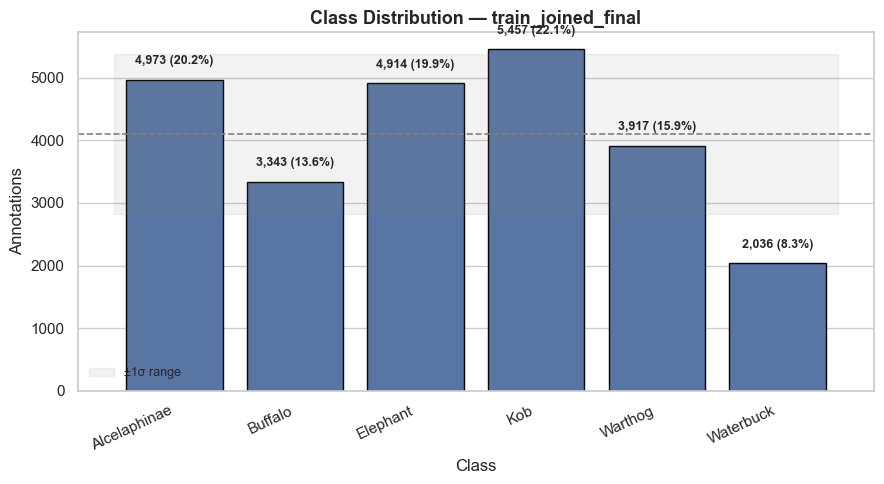

[2025-10-22 02:30:12,449] INFO: [PLOT] Saved class distribution plot -> C:\Users\Jaime\Documents\Projects\animal-count\data\outputs\reports_quality\train_joined_final\train_joined_final_class_distribution_20251022_023011.png


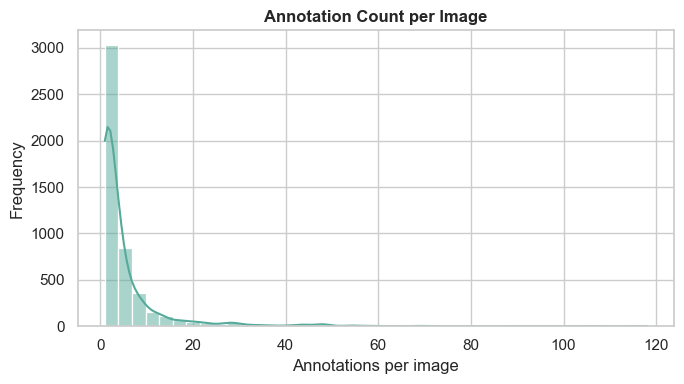

[2025-10-22 02:30:12,981] INFO: [PLOT] Saved annotations-per-image histogram -> C:\Users\Jaime\Documents\Projects\animal-count\data\outputs\reports_quality\train_joined_final\train_joined_final_annotations_per_image_20251022_023011.png


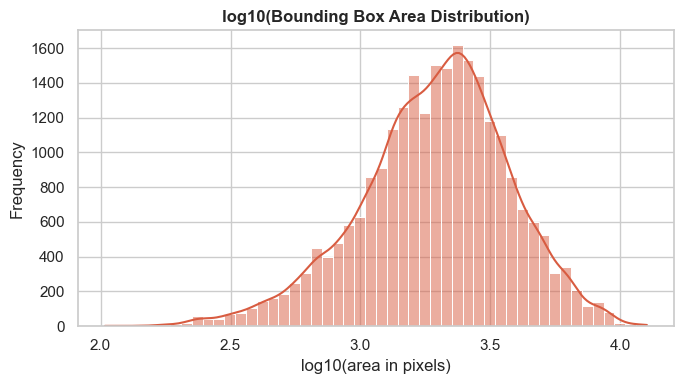

[2025-10-22 02:30:14,074] INFO: [PLOT] Saved bbox area distribution plot -> C:\Users\Jaime\Documents\Projects\animal-count\data\outputs\reports_quality\train_joined_final\train_joined_final_bbox_area_distribution_20251022_023011.png
[2025-10-22 02:30:14,076] INFO: [VERIFY] Summary saved -> C:\Users\Jaime\Documents\Projects\animal-count\data\outputs\reports_quality\train_joined_final\quality_summary_20251022_023011.json
[2025-10-22 02:30:14,111] INFO: [RUN] Quality check finished for 'train_joined_final' | Images valid: 4794 | Corrupted: 0 | Duplicates: 18
[02:30:14] INFO: [MAIN] Post-augmentation quality verification completed successfully.
[02:30:14] INFO: [MAIN] Quality check summary:
[02:30:14] INFO: {'status': 'success', 'filtered': {'removed': 0, 'kept': 4812}, 'report': {'images_total': 4812, 'images_valid': 4794, 'images_corrupted': 0, 'duplicates': 18, 'annotations_total': 24640, 'categories': 6}, 'json_path': 'C:\\Users\\Jaime\\Documents\\Projects\\animal-count\\data\\outputs\

In [4]:
import yaml
import logging
from pathlib import Path

# ==========================================================
# CONFIGURATION & LOGGER SETUP
# ==========================================================

# Path to the YAML configuration
CONFIG_PATH = Path("augmentation_config.yaml")

# Load configuration file
with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

# ==========================================================
# LOGGER INITIALIZATION
# ==========================================================
logger = logging.getLogger("PostAugmentationQualityRunner")
logger.setLevel(logging.INFO)

if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
        "[%(asctime)s] %(levelname)s: %(message)s", datefmt="%H:%M:%S"
    )
    handler.setFormatter(formatter)
    logger.addHandler(handler)

logger.propagate = False
logger.info("Starting post-augmentation quality check...")

# ==========================================================
# QUALITY CHECK EXECUTION
# ==========================================================
try:
    # Initialize the auditor
    checker = PostAugmentationQuality(yaml_path=str(CONFIG_PATH), num_workers=8, verbose=True)

    # Run the audit (plots enabled, max 150 annotations per image)
    results = checker.run(show=True, max_annotations=150)

    logger.info("[MAIN] Post-augmentation quality verification completed successfully.")
except Exception as e:
    logger.error(f"[MAIN] Quality verification failed: {e}", exc_info=True)
    results = {"status": "failed", "error": str(e)}

# ==========================================================
# FINAL SUMMARY OUTPUT
# ==========================================================
logger.info("[MAIN] Quality check summary:")
logger.info(results)